In [1]:
import os

import numpy as np

import nengo
from nengo.params import Default, NumberParam
from nengo.utils.matplotlib import rasterplot
from nengo.dists import Uniform
from nengo.solvers import LstsqL2, NoSolver
from nengo.utils.numpy import rmse

from nengolib.signal import s, nrmse, LinearSystem
from nengolib.synapses import Lowpass

from nengo_bioneurons import make_stimulus, norms

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='poster', style='whitegrid')
%matplotlib inline

/home/pduggins/.virtualenvs/nengo_bioneuron/local/lib/python2.7/site-packages/nengo/builder/builder.py:234: UserWarning: Type '<class 'nengo.connection.Connection'>' already has a builder. Overwriting.
  % nengo_class)


In [2]:
from nengo.neurons import *
from nengo.builder.neurons import *

class WilsonNeuron(NeuronType):
    """
    Wilson Neuron Model.
    
    Description
    -----------
    
    TODO
    
    Paramters
    ---------
    
    time constants in seconds
    voltages in mV
    
    References
    ----------
    [1] Wilson, Hugh R. "Simplified dynamics of human and mammalian neocortical neurons."
        Journal of theoretical biology 200.4 (1999): 375-388.

    
    """
    
    probeable = ('spikes', 'voltage', 'recovery', 'conductance', 'AP')
    threshold = NumberParam('threshold')
    tau_V = NumberParam('tau_V')
    tau_R = NumberParam('tau_R')
    tau_H = NumberParam('tau_H')
    
    def __init__(self, threshold=-0.20, tau_V=0.00097, tau_R=0.0056, tau_H=0.0990):
        super(WilsonNeuron, self).__init__()
        self.threshold = threshold
        self.tau_V = tau_V
        self.tau_R = tau_R
        self.tau_H = tau_H
        
    @property
    def _argreprs(self):
        args = []
        def add(attr, default):
            if getattr(self, attr) != default:
                args.append("%s=%s" %(attr, getattr(self, attr)))
        add("threshold", -0.20)
        add("tau_V", 0.00097)
        add("tau_R", 0.0056)
        add("tau_H", 0.0990)
        return args
        
    def rates(self, x, gain, bias):
        return x  # todo
    
    def gain_bias(self, max_rates, intercepts):
        return np.ones(len(max_rates)), np.ones(len(max_rates))  # todo
    
    def step_math(self, dt, J, spiked, voltage, recovery, conductance, AP):

        dV = -(17.81 + 47.58*voltage + 33.80*np.square(voltage))*(voltage - 0.48) - 26*recovery*(voltage + 0.95) - 13*conductance*(voltage + 0.95) + J
        dR = -recovery + 1.29*voltage + 0.79 + 3.30*np.square(voltage + 0.38)
        dH = -conductance + 11*(voltage + 0.754)*(voltage + 0.69)
        
        voltage[:] = (voltage + dV * dt/self.tau_V).clip(-0.9, 0.3)
        recovery[:] = (recovery + dR * dt/self.tau_R)  # .clip(0.18, 0.42)
        conductance[:] = (conductance + dH * dt/self.tau_H)  # .clip(0, 0.23)
        spiked[:] = (voltage > self.threshold) & (~AP)
        spiked /= dt
        AP[:] = voltage > self.threshold
        
#         voltage[:] += dV * dt/self.tau_V
#         recovery[:] += dR * dt/self.tau_R
#         conductance[:] += dH * dt/self.tau_H
#         spiked[:] = (voltage > self.threshold) & (~AP)
#         spiked /= dt
#         AP[:] = voltage > self.threshold



@Builder.register(WilsonNeuron)
def build_wilsonneuron(model, neuron_type, neurons):
    model.sig[neurons]['voltage'] = Signal(
        -0.754*np.ones(neurons.size_in), name="%s.voltage" % neurons)
    model.sig[neurons]['recovery'] = Signal(
        0.279*np.ones(neurons.size_in), name="%s.recovery" % neurons)
    model.sig[neurons]['conductance'] = Signal(
        0.0*np.ones(neurons.size_in), name="%s.conductance" % neurons)
    model.sig[neurons]['AP'] = Signal(
        np.zeros(neurons.size_in, dtype=bool), name="%s.AP" % neurons)
    model.add_op(SimNeurons(
        neurons=neuron_type,
        J=model.sig[neurons]['in'],
        output=model.sig[neurons]['out'],
        states=[model.sig[neurons]['voltage'],
            model.sig[neurons]['recovery'],
            model.sig[neurons]['conductance'],
            model.sig[neurons]['AP']]))

In [3]:
def simulate(  
    d,
    t=1,
    dt=0.001,
    dt_sample=0.001,
    n_neurons=100,
    n_pre=100,
    signal='cos',
    freq=1,
    amp=1,
    reg=0.01,
    n_unroll=0,
    taus={'network': 0.1, 'readout': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5},
    neuron_type=nengo.LIF(),
    max_rates=Default,
    gain=Default,
    bias=Default,
    plot=False,
    update=False):
    
    # transform input signal u so that the integral x is normalized to np.max(x)==1
    norm, norm_s, norm_f = norms(signal, freq, amp, seeds['ss'], taus['network'], t/2, dt=dt, plot=False)
    
    # Simulate the full network, skipping simulation of supv or bio when possible.
    with nengo.Network(seed=seeds['ns']) as model:
        model.T = t
        def flip(t, x):
            if t<model.T/2: return x
            elif t>=model.T/2: return -1.0*x
        u_raw = make_stimulus(signal, freq, amp, T=t/2, seed=seeds['ss'])
        u = nengo.Node(output=flip, size_in=1)
        pre_u = nengo.Ensemble(n_pre, 1, max_rates=max_rates, seed=seeds['es'], radius=norm_s)
        pre_x = nengo.Ensemble(n_pre, 1, max_rates=max_rates, seed=seeds['es'], radius=norm)
        ens_list = []
        for n in range(n_unroll+1):
            ens_list.append(
                nengo.Ensemble(n_neurons, 1, gain=gain, bias=bias, max_rates=max_rates,
                    neuron_type=neuron_type, seed=seeds['es'], label='%s'%n))
        unsupv = nengo.Ensemble(n_neurons, 1, gain=gain, bias=bias, max_rates=max_rates,
                neuron_type=neuron_type, seed=seeds['es'], label='unsupv')
        lif = nengo.Ensemble(n_neurons, 1, max_rates=max_rates, neuron_type=nengo.LIF(), seed=seeds['es'])
        tar = nengo.Ensemble(1, 1, neuron_type=nengo.Direct())

        # normal connections

        nengo.Connection(u_raw, u, synapse=None, seed=seeds['cs'])
        nengo.Connection(u, pre_u, synapse=None, seed=seeds['cs'])
        nengo.Connection(u, pre_x, synapse=1/s, seed=seeds['cs'])
        nengo.Connection(u, tar, synapse=1/s, transform=1.0/norm_f)
        nengo.Connection(pre_u, lif, synapse=taus['network'], transform=taus['network']/norm_f)
#         nengo.Connection(pre_x, lif, synapse=taus['network'], transform=1.0/norm_f)  # proxy for accuracy
        nengo.Connection(lif, lif, synapse=taus['network'])
        
        # supervised connections
        u_ens_list = []
        for n in range(n_unroll+1):
            u_ens_list.append(nengo.Connection(pre_u, ens_list[n],
                synapse=taus['network'],
                transform=taus['network']/norm_f,
                seed=seeds['cs']))
        ens_ens_list = []
        for n in range(n_unroll):
            ens_ens_list.append(nengo.Connection(ens_list[n], ens_list[n+1],
                synapse=taus['network'],
                solver=NoSolver(d),
                seed=seeds['cs']))
        nengo.Connection(pre_x, ens_list[0],
            synapse=taus['network'],
            transform=1.0/norm_f,
            seed=seeds['cs'])
        
        # unsupervised test
        nengo.Connection(pre_u, unsupv,
            synapse=taus['network'],
            transform=taus['network']/norm_f)
        nengo.Connection(unsupv, unsupv,
            synapse=taus['network'],
            solver=NoSolver(d),
            seed=seeds['cs'])

        # probes (down sample to dt_sample in post-processing for spiking ensembles)
        p_stim = nengo.Probe(u, synapse=None, sample_every=dt)
        p_target = nengo.Probe(tar, synapse=None, sample_every=dt)
        p_spike_list = []
        for n in range(n_unroll+1):
            p_spike_list.append(nengo.Probe(ens_list[n].neurons, synapse=None, sample_every=dt))
        p_unsupv = nengo.Probe(unsupv, solver=NoSolver(d), synapse=taus['readout'], sample_every=dt)
        p_spikes_unsupv = nengo.Probe(unsupv.neurons, synapse=None, sample_every=dt)
        p_spk_lif = nengo.Probe(lif.neurons, sample_every=dt)
        p_act_lif = nengo.Probe(lif.neurons, synapse=taus['readout'], sample_every=dt)
        p_lif = nengo.Probe(lif, synapse=taus['readout'], sample_every=dt)
        

    # Run the simulation        
    with nengo.Simulator(model, seed=seeds['ss'], dt=dt, progress_bar=False) as sim:
        sim.run(t, progress_bar=True)

    ''' Collect spikes, activities and lif estimates '''
#     lpf = Lowpass(taus['readout'])
    lpf = nengo.Lowpass(taus['readout'])
    stim = lpf.filt(sim.data[p_stim], dt=dt)[::int(dt_sample/dt)]
    target = lpf.filt(sim.data[p_target], dt=dt)[::int(dt_sample/dt)]
    times = dt_sample * np.arange(0, len(target), 1)
    A = np.zeros((n_unroll+1, len(times), n_neurons))
    A_stack = np.zeros((len(times)*(n_unroll+1), n_neurons))
    A_unsupv = np.zeros((len(times), n_neurons))
    Y = np.zeros((n_unroll+1, len(times), 1))
    Y_stack = np.zeros((len(times)*(n_unroll+1), 1))
    for n in range(n_unroll+1):
        A_full = lpf.filt(sim.data[p_spike_list[n]], dt=dt)
        A_downsampled = A_full[::int(dt_sample/dt)]
        assert A_downsampled.shape == A[n].shape
        A[n] = A_downsampled
        A_stack[n*len(times):(n+1)*len(times)] = A_downsampled
#         A[n] = lpf.filt(sim.data[p_spike_list[n]], dt=dt_sample)
#         A_stack[n*len(times):(n+1)*len(times)] = A[n]
        Y[n] = np.array(target)
        Y_stack[n*len(times):(n+1)*len(times)] = Y[n]
#     A = np.array([lpf.filt(sim.data[p_spike_list[n]], dt=dt_sample) for n in range(n_unroll+1)])
#     Y = np.array([target for n in range(n_unroll+1)])
    spikes_unsupv = sim.data[p_spikes_unsupv]
    spikes_lif = sim.data[p_spk_lif]
    act_lif = sim.data[p_act_lif][::int(dt_sample/dt)]
    xhat_lif = sim.data[p_lif][::int(dt_sample/dt)]
    assert xhat_lif.shape == target.shape
    nrmse_lif = nrmse(xhat_lif, target=target)

    ''' Compute new recurrent decoder from a stacked A and Y matrix '''
#     A_stack = np.vstack(A)
#     Y_stack = np.vstack(Y)
    d_new = LstsqL2(reg=reg)(A_stack, Y_stack)[0]
    xhats = np.zeros_like(Y)
    nrmses = np.zeros((n_unroll+1))
    for n in range(n_unroll+1):
        xhats[n] = np.dot(A[n], d)
        nrmses[n] = nrmse(xhats[n], target=target)
#     xhats = [np.dot(A[n], d) for n in range(n_unroll+1)]
#     nrmses = [nrmse(xhats[n], target=target) for n in range(n_unroll+1)]
    xhat_unsupv = sim.data[p_unsupv][::int(dt_sample/dt)]
    A_unsupv = lpf.filt(spikes_unsupv, dt=dt)[::int(dt_sample/dt)]
    assert xhat_unsupv.shape == target.shape
    nrmse_unsupv = nrmse(xhat_unsupv, target=target)

    ''' Plot 'em, mash 'em, stick 'em in a stew '''
    if plot:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
        rasterplot(sim.trange(), spikes_unsupv, ax=ax1)
#         ax2.plot(times, lpf.filt(sim.data[p_spike_list[-1]], dt=dt_sample))
        ax2.plot(times, A_unsupv)
        ax1.set(xlabel='time', ylabel='neuron')
        ax2.set(xlabel='time', ylabel='firing rate (Hz)')
        plt.tight_layout()

        fig, ax1 = plt.subplots(1, 1, figsize=(8, 4))
        for n in range(n_unroll+1):
            sns.distplot(np.ravel(A[n]), ax=ax1, label='%s unrolling' %n)
        sns.distplot(np.ravel(A_unsupv), ax=ax1, label='unsupervised')
        ax1.set(xlim=((1, 400)), ylim=((0, 0.03)), xlabel='firing rate (Hz)', ylabel='frequency')
        plt.legend()
        plt.tight_layout()

        cmap = sns.color_palette('hls', n_unroll)
        fig, ax = plt.subplots(1, 1, figsize=(8, 4))
#         ax.plot(times, sim.data[p_stim], label='input')
        ax.plot(times, target, label='target', linestyle='--')
        ax.plot(times, xhat_lif, alpha=0.5, label='lif, nrmse=%.3f' %nrmse_lif)
        for n in range(n_unroll+1):
            ax.plot(times, xhats[n], alpha=0.5, label='unroll %s, nrmse=%.3f' %(n, nrmses[n]))
        ax.plot(times, xhat_unsupv, label='unsupervised, nrmse=%.3f' %nrmse_unsupv)
        ax.set(xlabel='time', ylabel='$\mathbf{x}$')
        ax.legend(loc='lower left')
        plt.tight_layout()
        plt.show()

    return d_new, nrmse_unsupv

## Control structure

In [5]:
def unroll_best(n_unroll, signal='cos', plot=False, **kwargs):
    d = np.zeros((kwargs['n_neurons'], 1))
    nrmses = np.zeros((n_unroll+1))
    ds = np.zeros((n_unroll+1, kwargs['n_neurons'], 1))
    for n in range(n_unroll+1):
        print "unrolling #%s" %n
        ds[n] = d
        d, nrmse = simulate(d, n_unroll=n, update=True, plot=plot, signal=signal, **kwargs)
        nrmses[n] = nrmse
        print 'nrmse = %.3f' %nrmse

    fig, ax = plt.subplots(1, 1, figsize=((8, 4)))
    ax.plot(np.arange(0, n_unroll+1), nrmses)
    ax.set(xlabel='unrollings', ylabel='nrmse')
    plt.show()
    
    d_best = ds[np.argmin(nrmses)]

    _, _ = simulate(d_best, n_unroll=0, plot=True, signal='cos', **kwargs)
    _, _ = simulate(d_best, n_unroll=0, plot=True, signal='white_noise', **kwargs)
    
    return d_best

# Simulations

## LIF

unrolling #0
Simulating finished in 0:00:18.                                                 
nrmse = 1.000
unrolling #1
Simulating finished in 0:00:20.                                                 
nrmse = 0.215
unrolling #2
Simulating finished in 0:00:29.                                                 
nrmse = 0.031
unrolling #3
Simulating finished in 0:00:28.                                                 
nrmse = 0.029
unrolling #4
Simulating finished in 0:00:26.                                                 
nrmse = 0.016
unrolling #5
Simulating finished in 0:00:33.                                                 
nrmse = 0.022
unrolling #6
Simulating finished in 0:00:36.                                                 
nrmse = 0.006
unrolling #7
Simulating finished in 0:00:30.                                                 
nrmse = 0.058
unrolling #8
Simulating finished in 0:00:29.                                                 
nrmse = 0.212
unrolling #9
Simulating fini

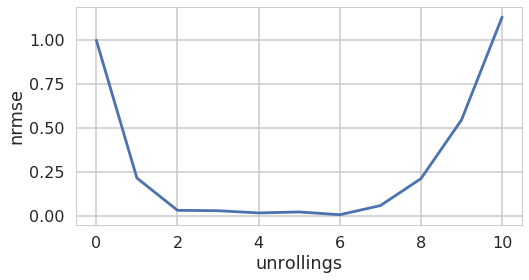

Simulating finished in 0:00:24.                                                 


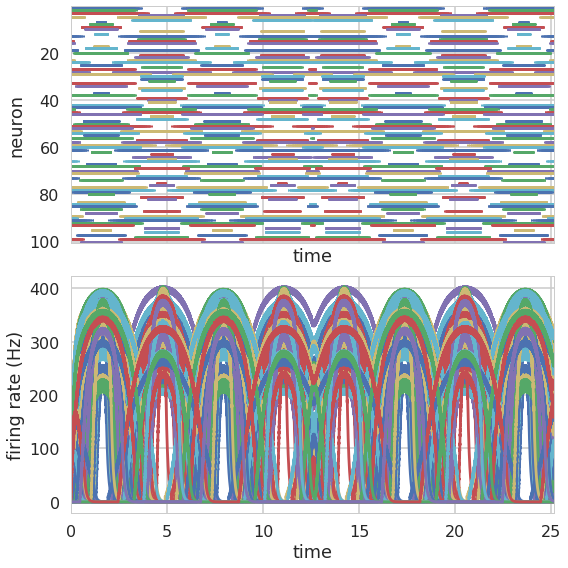

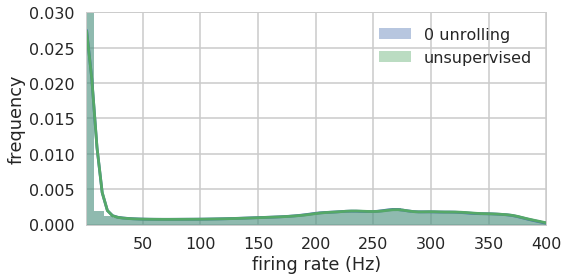

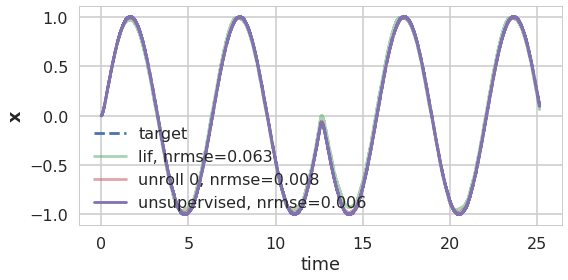

Simulating finished in 0:00:18.                                                 


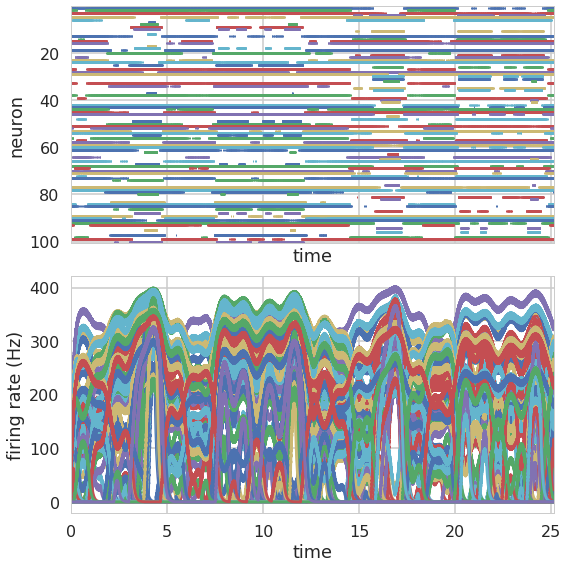

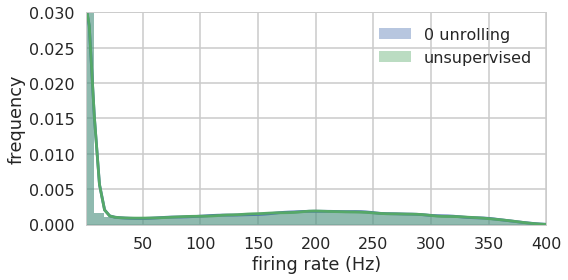

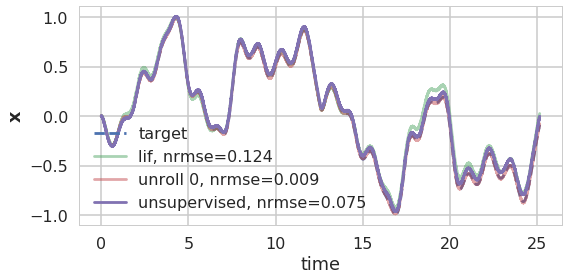

In [6]:
kwargs = dict(
    t=8*np.pi,
    dt=0.001,
    dt_sample=0.001,
    n_neurons=100,
    n_pre=100,
    freq=1,
    amp=1,
    reg=0.01,
    gain=Default,
    bias=Default,
    max_rates=Default,
    neuron_type=nengo.LIF(),
    taus={'network': 0.1, 'readout': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5})

d_best = unroll_best(n_unroll=10, plot=False, signal='cos', **kwargs)

unrolling #0
Simulating finished in 0:00:23.                                                 
nrmse = 1.000
unrolling #1
Simulating finished in 0:00:29.                                                 
nrmse = 0.170
unrolling #2
Simulating finished in 0:00:26.                                                 
nrmse = 0.068
unrolling #3
Simulating finished in 0:00:30.                                                 
nrmse = 0.069
unrolling #4
Simulating finished in 0:00:28.                                                 
nrmse = 0.022
unrolling #5
Simulating finished in 0:00:30.                                                 
nrmse = 0.069
unrolling #6
Simulating finished in 0:00:34.                                                 
nrmse = 0.073
unrolling #7
Simulating finished in 0:00:34.                                                 
nrmse = 0.209
unrolling #8
Simulating finished in 0:00:39.                                                 
nrmse = 0.470
unrolling #9
Simulating fini

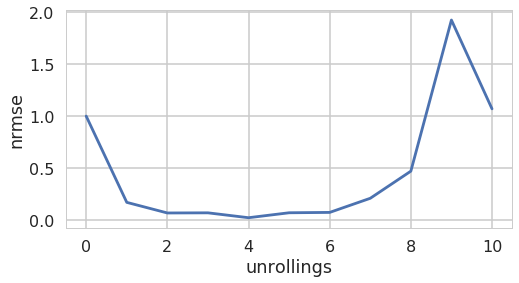

Simulating finished in 0:00:25.                                                 


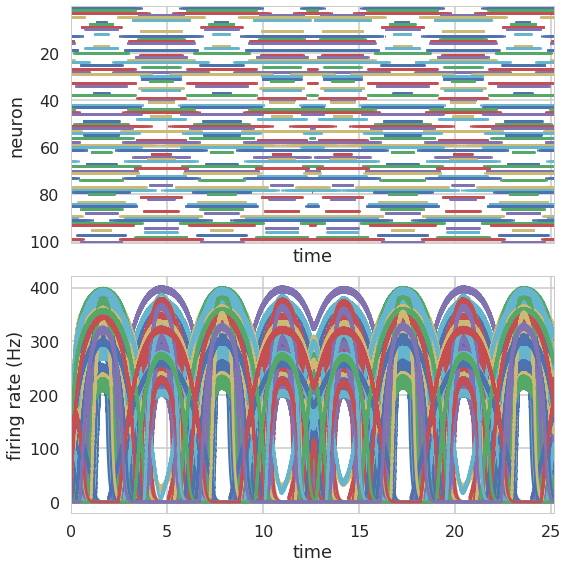

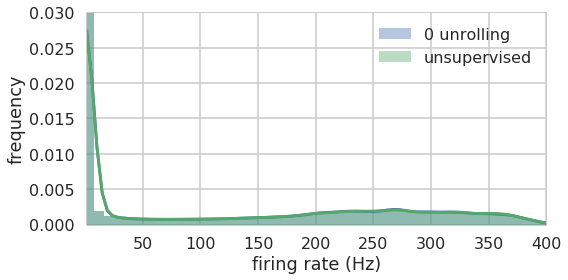

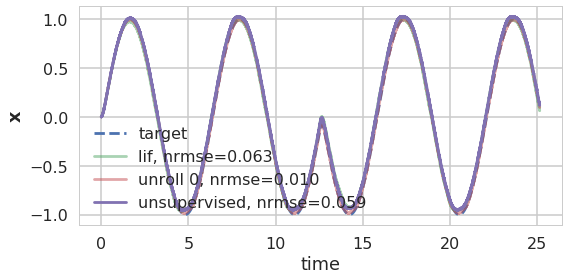

Simulating finished in 0:00:19.                                                 


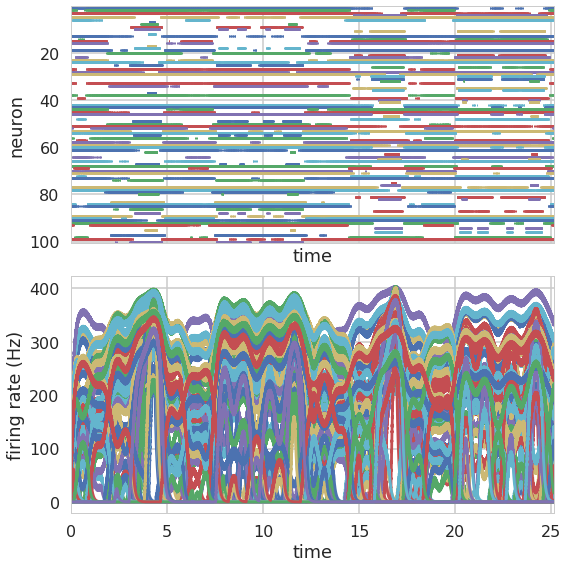

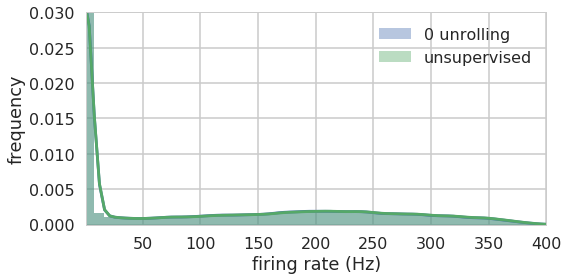

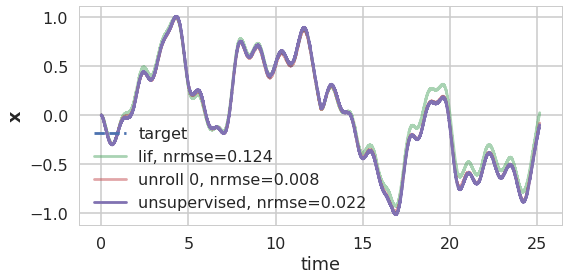

In [8]:
kwargs = dict(
    t=8*np.pi,
    dt=0.001,
    dt_sample=0.001,
    n_neurons=100,
    n_pre=100,
    freq=1,
    amp=1,
    reg=0.01,
    gain=Default,
    bias=Default,
    max_rates=Default,
    neuron_type=nengo.LIF(),
    taus={'network': 0.1, 'readout': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5})

d_best = unroll_best(n_unroll=10, signal='white_noise', plot=False, **kwargs)

### dt=0.0001 (10x smaller than default, dt_sample unchanged)

unrolling #0
Simulating finished in 0:03:38.                                                 
nrmse = 1.000
unrolling #1
Simulating finished in 0:04:26.                                                 
nrmse = 0.205
unrolling #2
Simulating finished in 0:03:54.                                                 
nrmse = 0.028
unrolling #3
Simulating finished in 0:04:47.                                                 
nrmse = 0.023
unrolling #4
Simulating finished in 0:05:04.                                                 
nrmse = 0.017
unrolling #5
Simulating finished in 0:05:14.                                                 
nrmse = 0.014
unrolling #6
Simulating finished in 0:05:03.                                                 
nrmse = 0.019
unrolling #7
Simulating finished in 0:05:25.                                                 
nrmse = 0.030
unrolling #8
Simulating finished in 0:07:15.                                                 
nrmse = 0.147
unrolling #9
Simulating fini

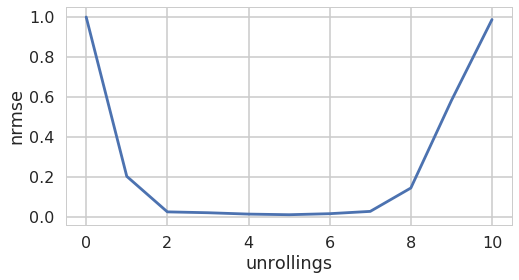

Simulating finished in 0:03:29.                                                 


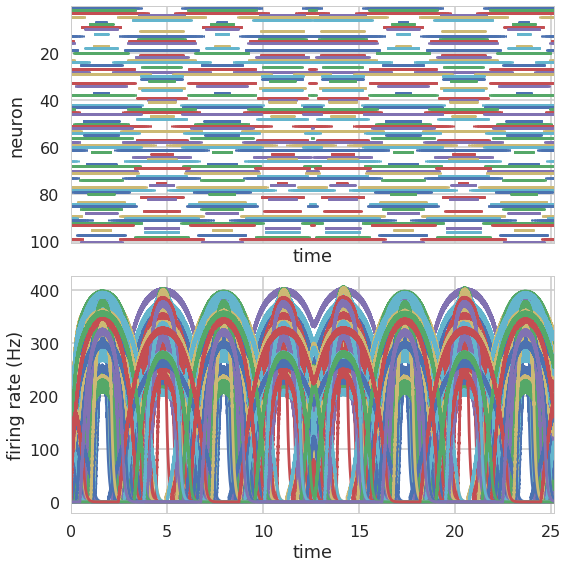

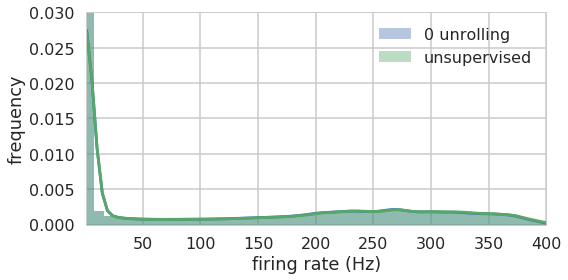

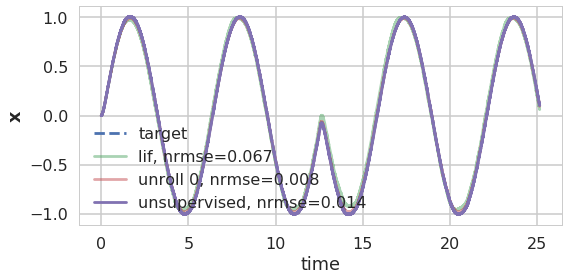

Simulating finished in 0:03:03.                                                 


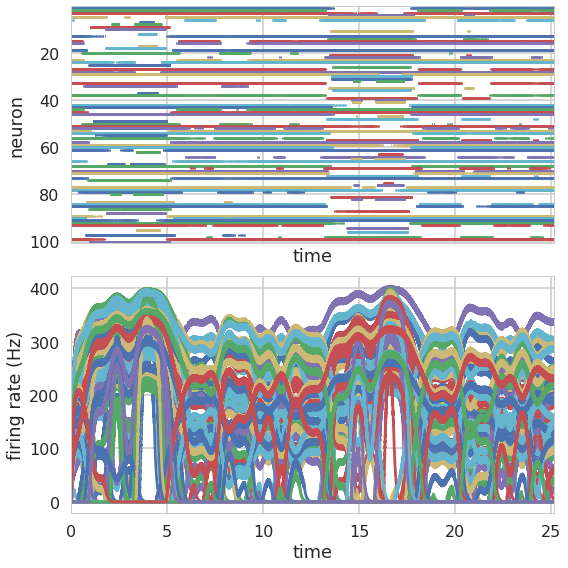

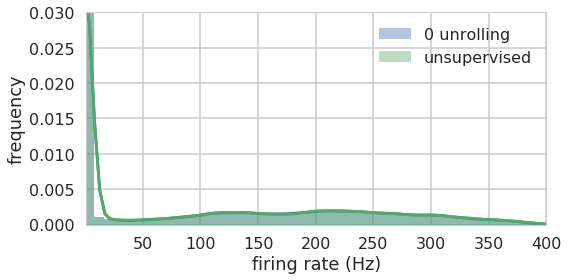

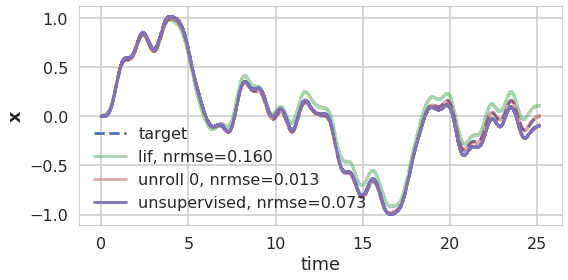

In [9]:
kwargs = dict(
    t=8*np.pi,
    dt=0.0001,
    dt_sample=0.001,
    n_neurons=100,
    n_pre=100,
    freq=1,
    amp=1,
    reg=0.01,
    gain=Default,
    bias=Default,
    max_rates=Default,
    neuron_type=nengo.LIF(),
    taus={'network': 0.1, 'readout': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5})

d_best = unroll_best(n_unroll=10, **kwargs)

### 1000 neurons (up 10x from default)

unrolling #0
Simulating finished in 0:00:28.                                                 
nrmse = 1.000
unrolling #1
Simulating finished in 0:00:32.                                                 
nrmse = 0.124
unrolling #2
Simulating finished in 0:00:30.                                                 
nrmse = 0.032
unrolling #3
Simulating finished in 0:00:38.                                                 
nrmse = 0.026
unrolling #4
Simulating finished in 0:00:38.                                                 
nrmse = 0.020
unrolling #5
Simulating finished in 0:00:48.                                                 
nrmse = 0.019
unrolling #6
Simulating finished in 0:00:40.                                                 
nrmse = 0.012
unrolling #7
Simulating finished in 0:00:44.                                                 
nrmse = 0.020
unrolling #8
Simulating finished in 0:00:46.                                                 
nrmse = 0.031
unrolling #9
Simulating fini

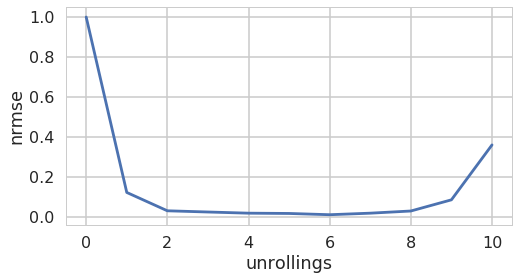

Simulating finished in 0:00:23.                                                 


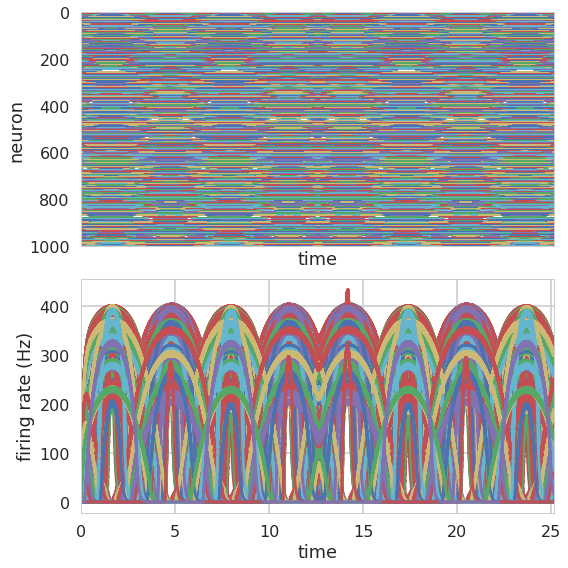

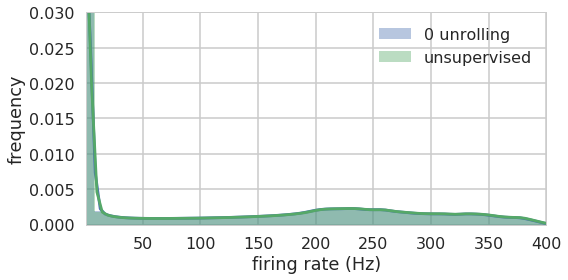

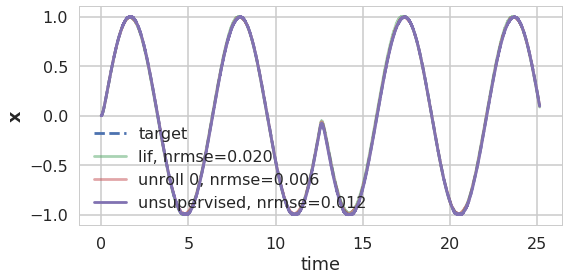

Simulating finished in 0:00:30.                                                 


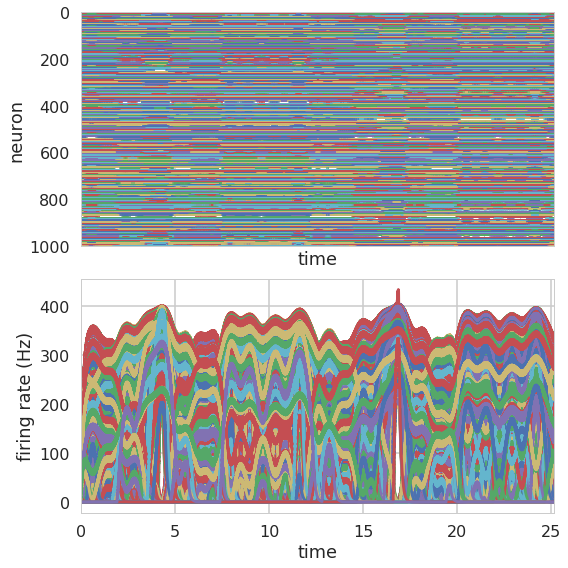

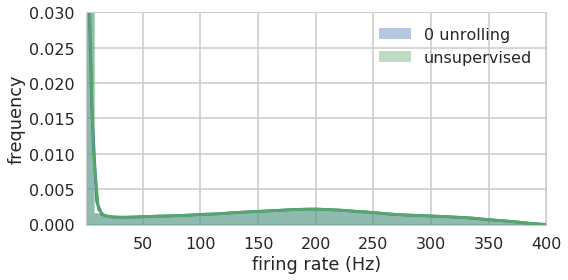

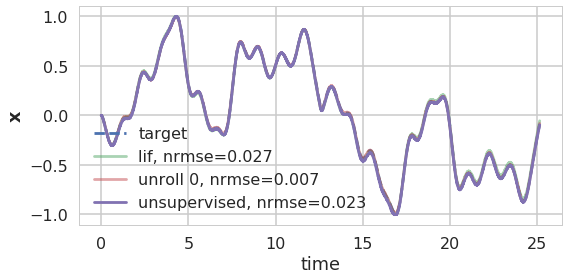

In [10]:
kwargs = dict(
    t=8*np.pi,
    dt=0.001,
    dt_sample=0.001,
    n_neurons=1000,
    n_pre=100,
    freq=1,
    amp=1,
    reg=0.01,
    gain=Default,
    bias=Default,
    max_rates=Default,
    neuron_type=nengo.LIF(),
    taus={'network': 0.1, 'readout': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5})

d_best = unroll_best(n_unroll=10, **kwargs)

## ALIF

unrolling #0
Simulating finished in 0:00:27.                                                 
nrmse = 1.000
unrolling #1
Simulating finished in 0:00:28.                                                 
nrmse = 0.204
unrolling #2
Simulating finished in 0:00:28.                                                 
nrmse = 0.109
unrolling #3
Simulating finished in 0:00:30.                                                 
nrmse = 0.094
unrolling #4
Simulating finished in 0:00:38.                                                 
nrmse = 0.091
unrolling #5
Simulating finished in 0:00:37.                                                 
nrmse = 0.078
unrolling #6
Simulating finished in 0:00:35.                                                 
nrmse = 0.086
unrolling #7
Simulating finished in 0:00:37.                                                 
nrmse = 0.057
unrolling #8
Simulating finished in 0:00:49.                                                 
nrmse = 0.119
unrolling #9
Simulating fini

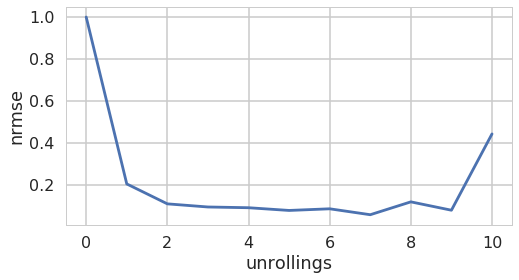

Simulating finished in 0:00:27.                                                 


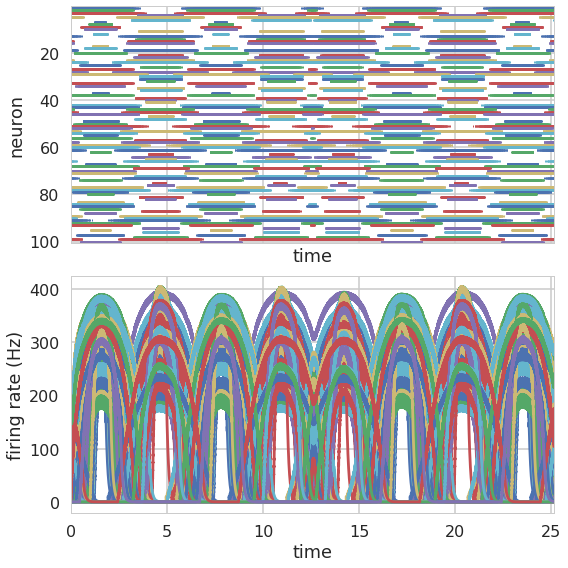

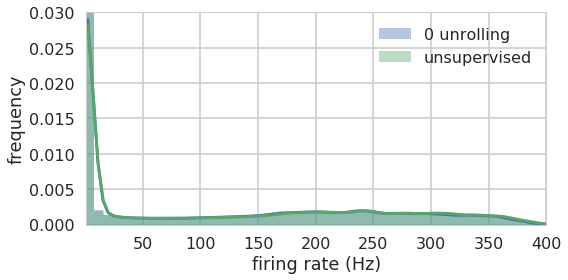

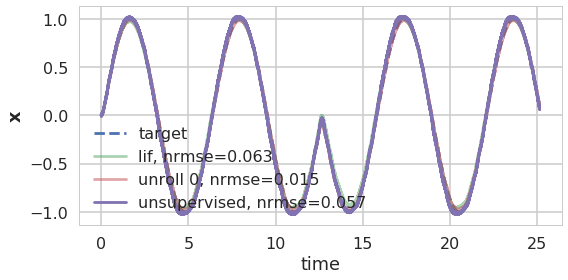

Simulating finished in 0:00:22.                                                 


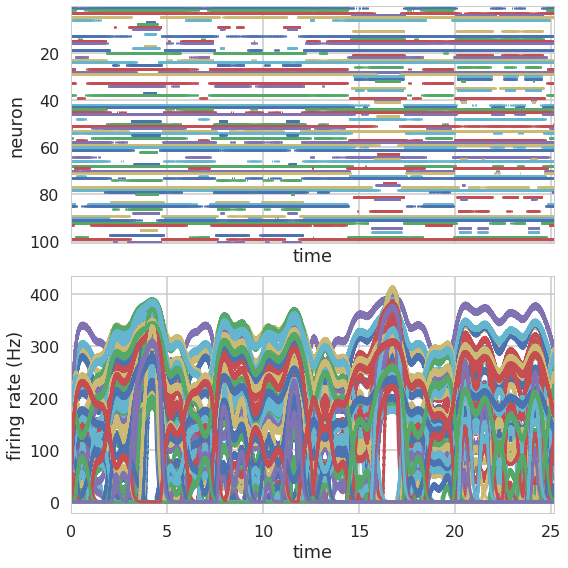

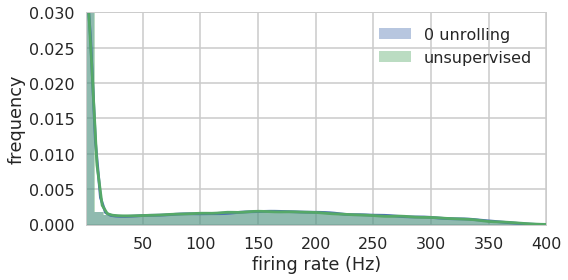

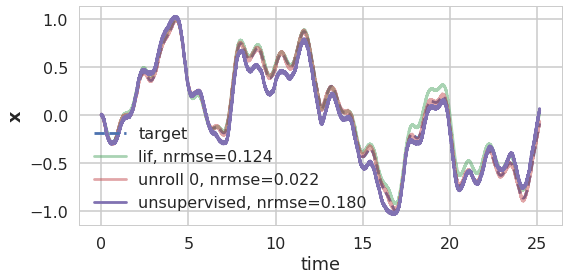

In [11]:
kwargs = dict(
    t=8*np.pi,
    dt=0.001,
    dt_sample=0.001,
    n_neurons=100,
    n_pre=100,
    freq=1,
    amp=1,
    reg=0.01,
    gain=Default,
    bias=Default,
    max_rates=Default,
    neuron_type=nengo.AdaptiveLIF(tau_n=0.1, inc_n=0.01),
    taus={'network': 0.1, 'readout': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5})

d_best = unroll_best(n_unroll=10, **kwargs)

### 10x greater adaptation (inc_n=0.1)

unrolling #0
Simulating finished in 0:00:20.                                                 
nrmse = 1.000
unrolling #1
Simulating finished in 0:00:25.                                                 
nrmse = 0.733
unrolling #2
Simulating finished in 0:00:27.                                                 
nrmse = 0.825
unrolling #3
Simulating finished in 0:00:34.                                                 
nrmse = 0.791
unrolling #4
Simulating finished in 0:00:27.                                                 
nrmse = 0.720
unrolling #5
Simulating finished in 0:00:42.                                                 
nrmse = 0.673
unrolling #6
Simulating finished in 0:00:36.                                                 
nrmse = 0.560
unrolling #7
Simulating finished in 0:00:37.                                                 
nrmse = 0.784
unrolling #8
Simulating finished in 0:00:38.                                                 
nrmse = 0.624
unrolling #9
Simulating fini

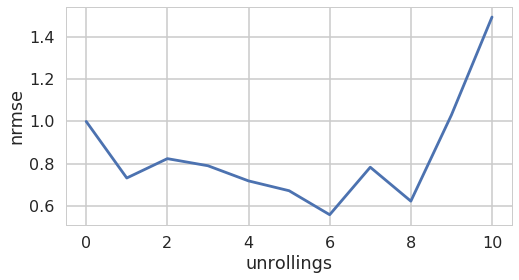

Simulating finished in 0:00:22.                                                 


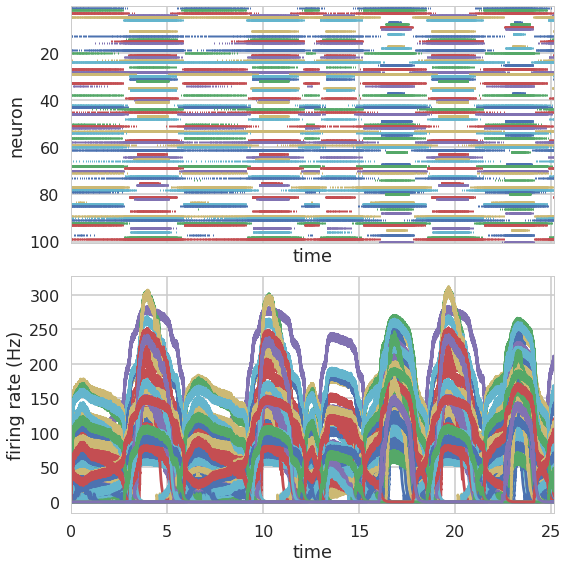

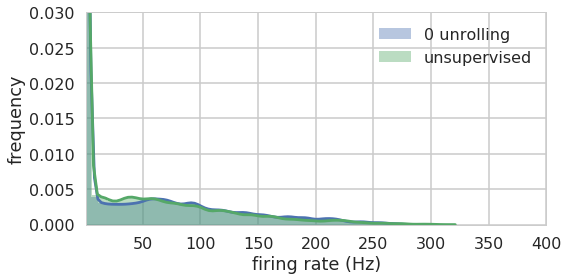

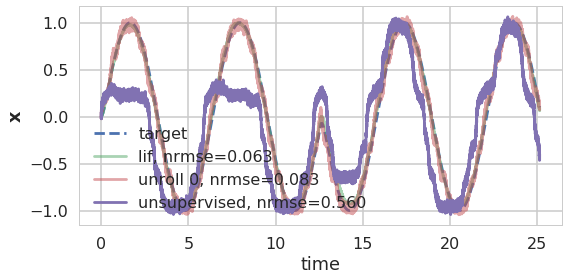

Simulating finished in 0:00:21.                                                 


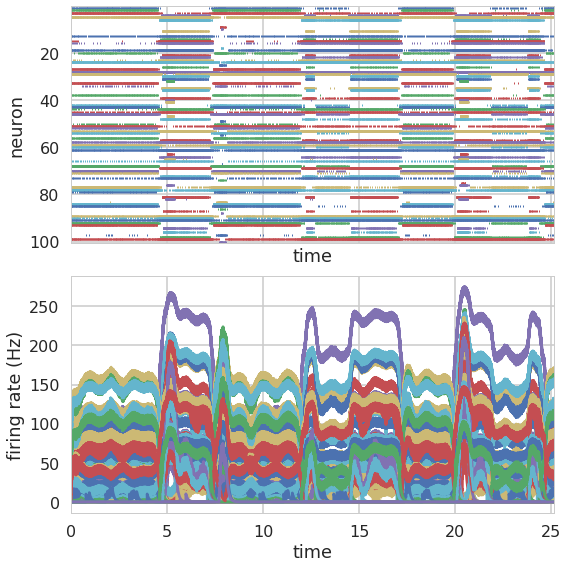

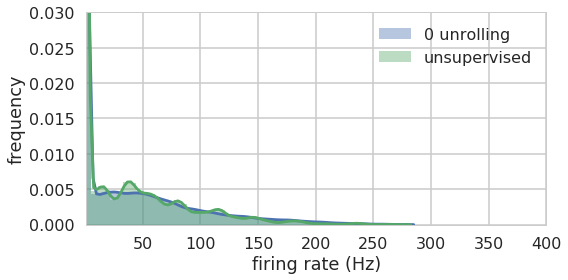

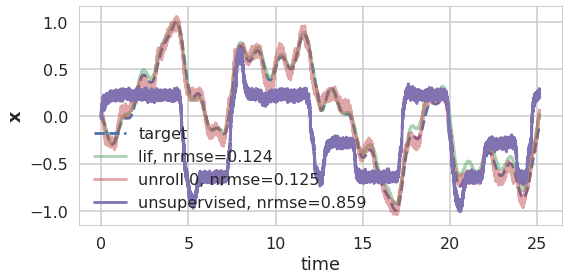

In [12]:
kwargs = dict(
    t=8*np.pi,
    dt=0.001,
    dt_sample=0.001,
    n_neurons=100,
    n_pre=100,
    freq=1,
    amp=1,
    reg=0.01,
    gain=Default,
    bias=Default,
    max_rates=Default,
    neuron_type=nengo.AdaptiveLIF(tau_n=0.1, inc_n=0.1),
    taus={'network': 0.1, 'readout': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5})

d_best = unroll_best(n_unroll=10, **kwargs)

### 0.1x regularization (reg=0.001)

unrolling #0
Simulating finished in 0:00:21.                                                 
nrmse = 1.000
unrolling #1
Simulating finished in 0:00:25.                                                 
nrmse = 0.739
unrolling #2
Simulating finished in 0:00:25.                                                 
nrmse = 0.737
unrolling #3
Simulating finished in 0:00:28.                                                 
nrmse = 0.675
unrolling #4
Simulating finished in 0:00:25.                                                 
nrmse = 0.679
unrolling #5
Simulating finished in 0:00:39.                                                 
nrmse = 0.697
unrolling #6
Simulating finished in 0:00:35.                                                 
nrmse = 0.675
unrolling #7
Simulating finished in 0:00:38.                                                 
nrmse = 0.671
unrolling #8
Simulating finished in 0:00:41.                                                 
nrmse = 1.682
unrolling #9
Simulating fini

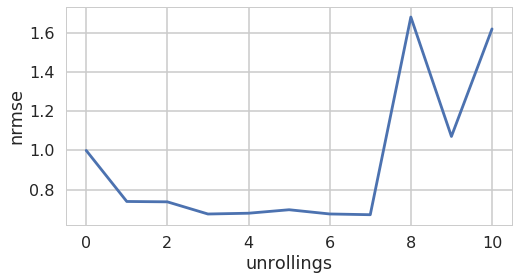

Simulating finished in 0:00:18.                                                 


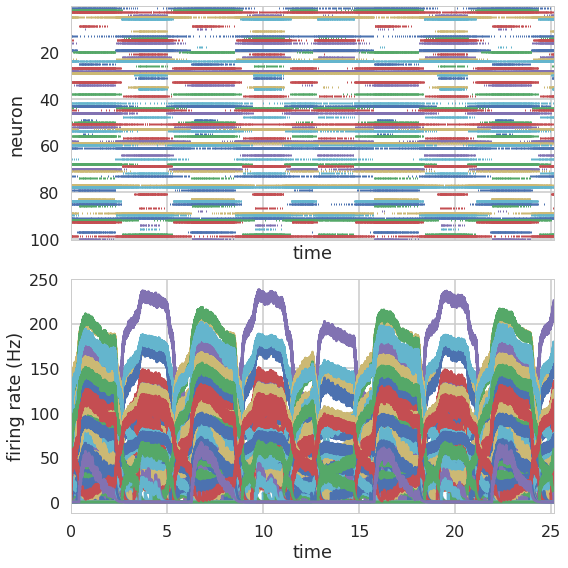

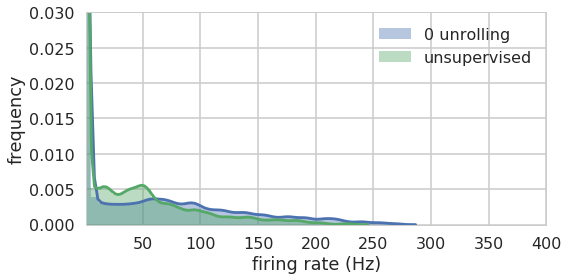

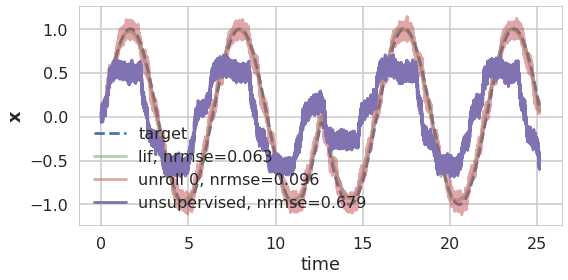

Simulating finished in 0:00:21.                                                 


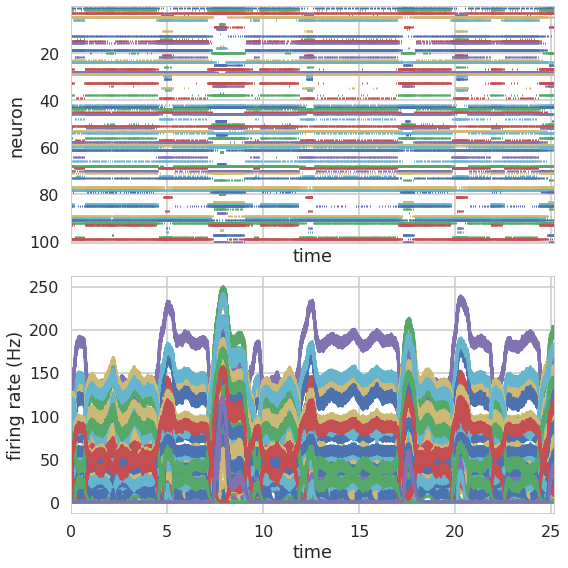

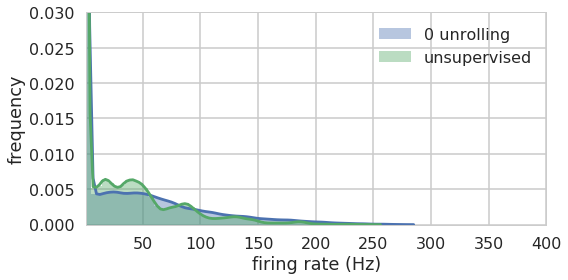

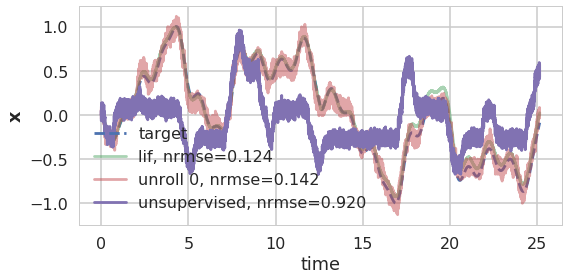

In [13]:
kwargs = dict(
    t=8*np.pi,
    dt=0.001,
    dt_sample=0.001,
    n_neurons=100,
    n_pre=100,
    freq=1,
    amp=1,
    reg=0.001,
    gain=Default,
    bias=Default,
    max_rates=Default,
    neuron_type=nengo.AdaptiveLIF(tau_n=0.1, inc_n=0.1),
    taus={'network': 0.1, 'readout': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5})

d_best = unroll_best(n_unroll=10, **kwargs)

### 1000 neurons

unrolling #0
Simulating finished in 0:00:22.                                                 
nrmse = 1.000
unrolling #1
Simulating finished in 0:00:30.                                                 
nrmse = 0.320
unrolling #2
Simulating finished in 0:00:34.                                                 
nrmse = 0.276
unrolling #3
Simulating finished in 0:00:35.                                                 
nrmse = 1.129
unrolling #4
Simulating finished in 0:00:44.                                                 
nrmse = 1.001
unrolling #5
Simulating finished in 0:00:36.                                                 
nrmse = 2.223
unrolling #6
Simulating finished in 0:00:45.                                                 
nrmse = 2.312
unrolling #7
Simulating finished in 0:00:42.                                                 
nrmse = 0.404
unrolling #8
Simulating finished in 0:00:50.                                                 
nrmse = 4.304
unrolling #9
Simulating fini

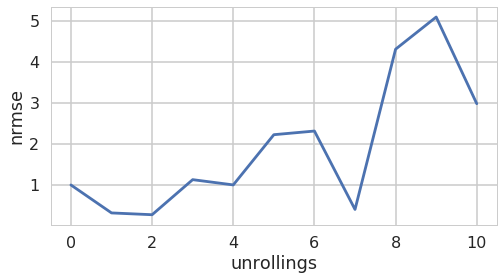

Simulating finished in 0:00:26.                                                 


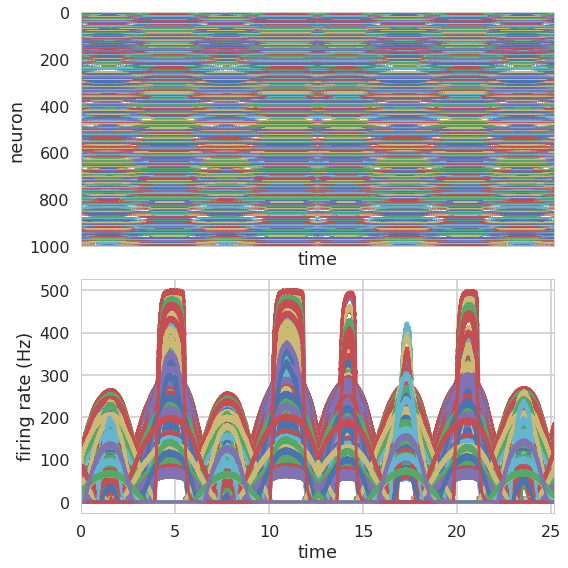

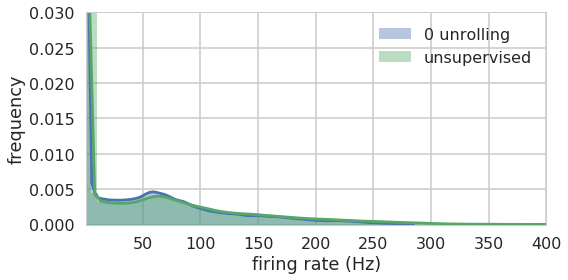

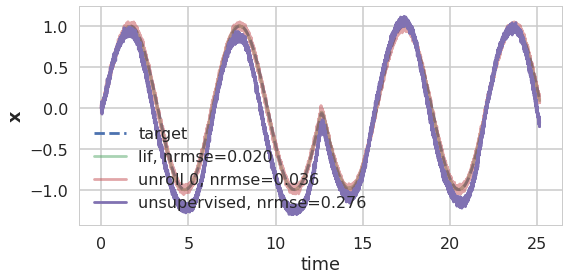

Simulating finished in 0:00:23.                                                 


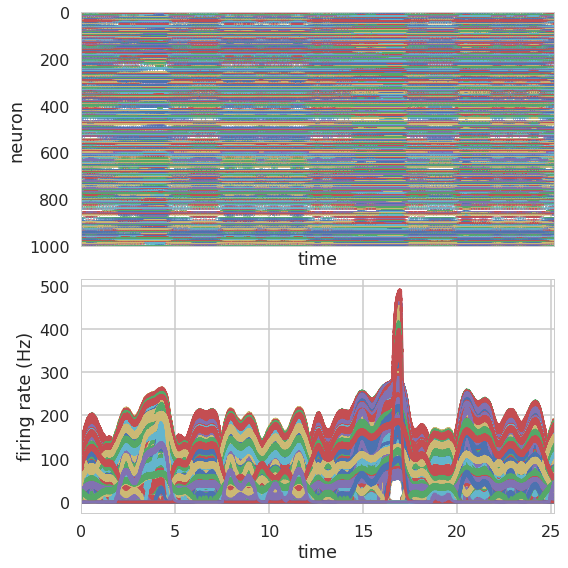

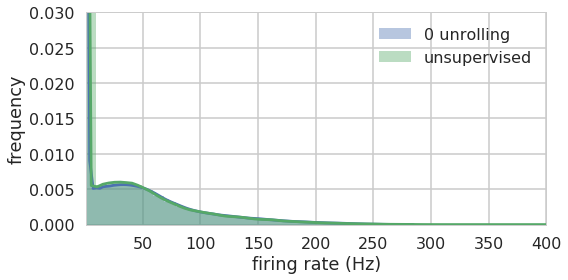

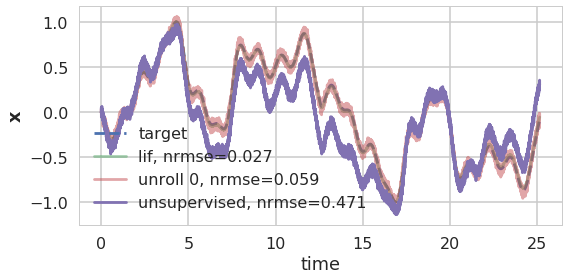

In [14]:
kwargs = dict(
    t=8*np.pi,
    dt=0.001,
    dt_sample=0.001,
    n_neurons=1000,
    n_pre=100,
    freq=1,
    amp=1,
    reg=0.001,
    gain=Default,
    bias=Default,
    max_rates=Default,
    neuron_type=nengo.AdaptiveLIF(tau_n=0.1, inc_n=0.1),
    taus={'network': 0.1, 'readout': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5})

d_best = unroll_best(n_unroll=10, **kwargs)

unrolling #0
Simulating finished in 0:00:24.                                                 
nrmse = 1.000
unrolling #1
Simulating finished in 0:00:25.                                                 
nrmse = 0.607
unrolling #2
Simulating finished in 0:00:30.                                                 
nrmse = 0.626
unrolling #3
Simulating finished in 0:00:27.                                                 
nrmse = 0.494
unrolling #4
Simulating finished in 0:00:39.                                                 
nrmse = 0.572
unrolling #5
Simulating finished in 0:00:38.                                                 
nrmse = 0.548
unrolling #6
Simulating finished in 0:00:38.                                                 
nrmse = 0.747
unrolling #7
Simulating finished in 0:00:36.                                                 
nrmse = 0.720
unrolling #8
Simulating finished in 0:00:42.                                                 
nrmse = 1.570
unrolling #9
Simulating fini

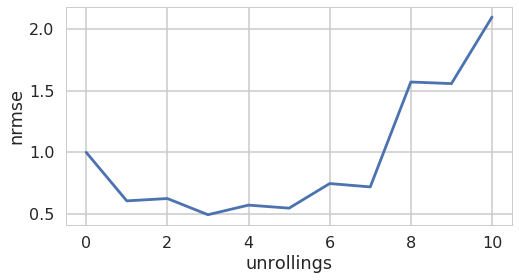

Simulating finished in 0:00:31.                                                 


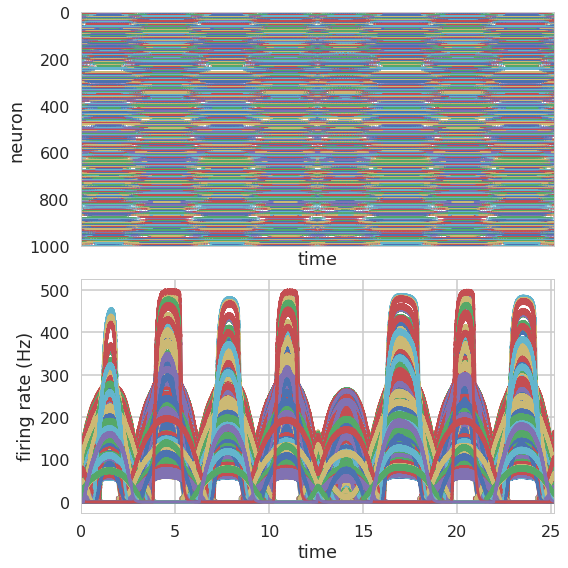

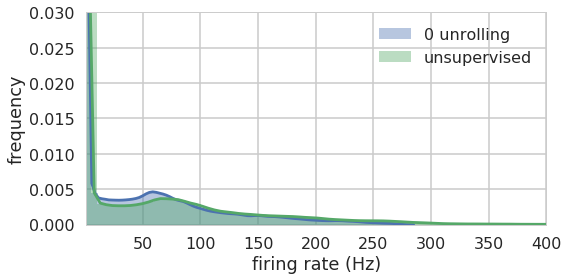

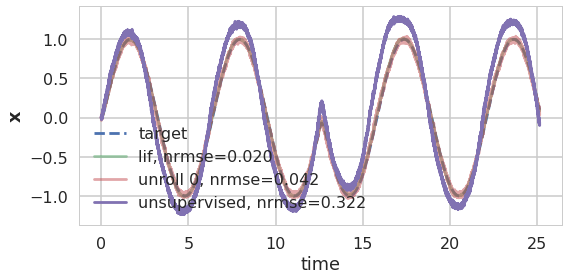

Simulating finished in 0:00:21.                                                 


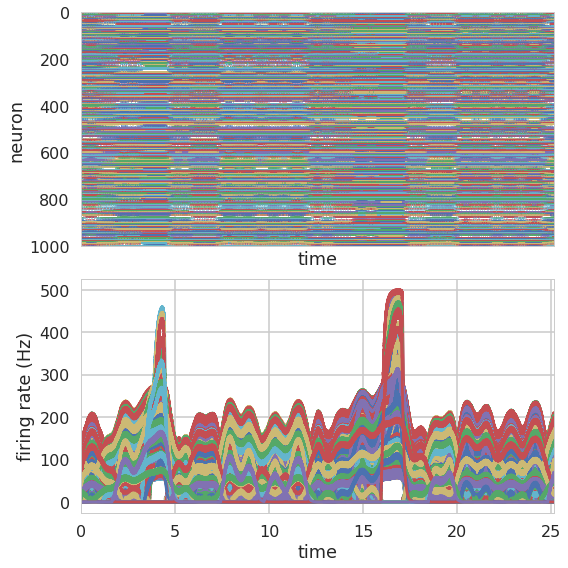

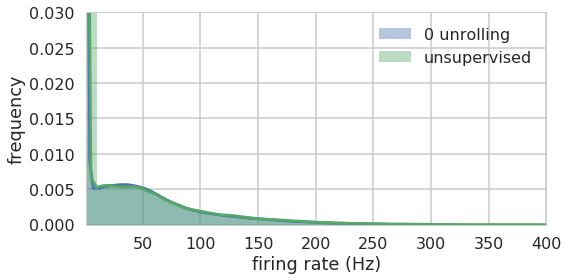

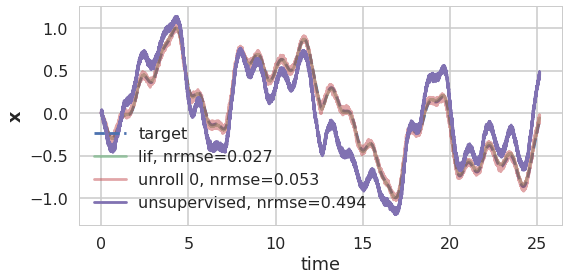

In [6]:
kwargs = dict(
    t=8*np.pi,
    dt=0.001,
    dt_sample=0.001,
    n_neurons=1000,
    n_pre=100,
    freq=1,
    amp=1,
    reg=0.01,
    gain=Default,
    bias=Default,
    max_rates=Default,
    neuron_type=nengo.AdaptiveLIF(tau_n=0.1, inc_n=0.1),
    taus={'network': 0.1, 'readout': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5})

d_best = unroll_best(n_unroll=10, signal='white_noise', **kwargs)

# Wilson Neuron

unrolling #0
Simulating finished in 0:03:09.                                                 
nrmse = 1.000
unrolling #1
Simulating finished in 0:04:18.                                                 
nrmse = 1.401
unrolling #2
Simulating finished in 0:04:02.                                                 
nrmse = 0.646
unrolling #3
Simulating finished in 0:03:54.                                                 
nrmse = 0.534
unrolling #4
Simulating finished in 0:04:11.                                                 
nrmse = 0.505
unrolling #5
Simulating finished in 0:05:27.                                                 
nrmse = 0.444
unrolling #6
Simulating finished in 0:04:56.                                                 
nrmse = 0.555
unrolling #7
Simulating finished in 0:05:34.                                                 
nrmse = 0.695
unrolling #8
Simulating finished in 0:05:20.                                                 
nrmse = 0.746
unrolling #9
Simulating fini

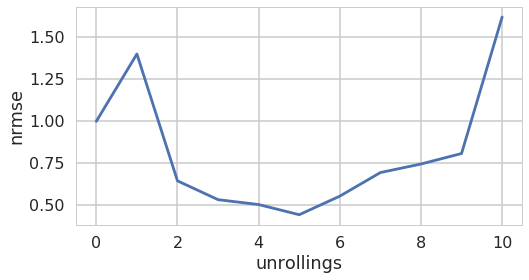

Simulating finished in 0:02:58.                                                 


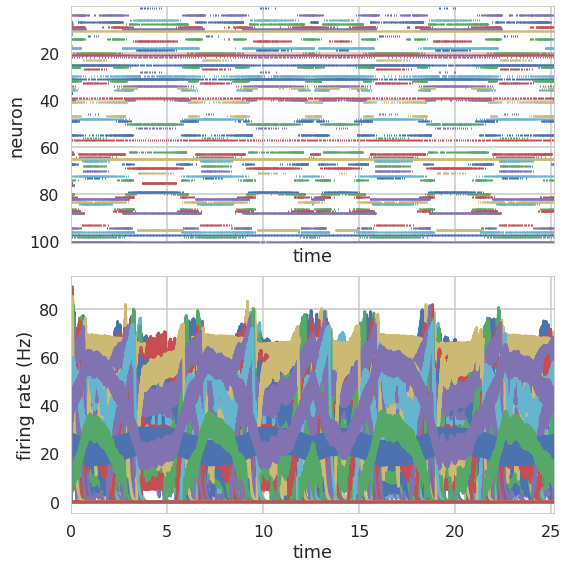

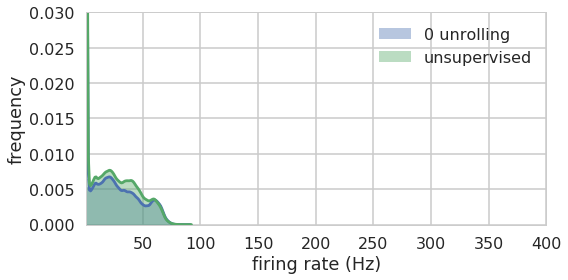

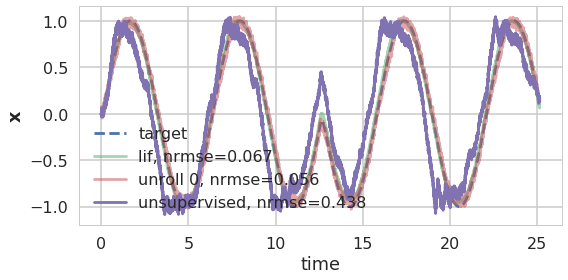

Simulating finished in 0:02:43.                                                 


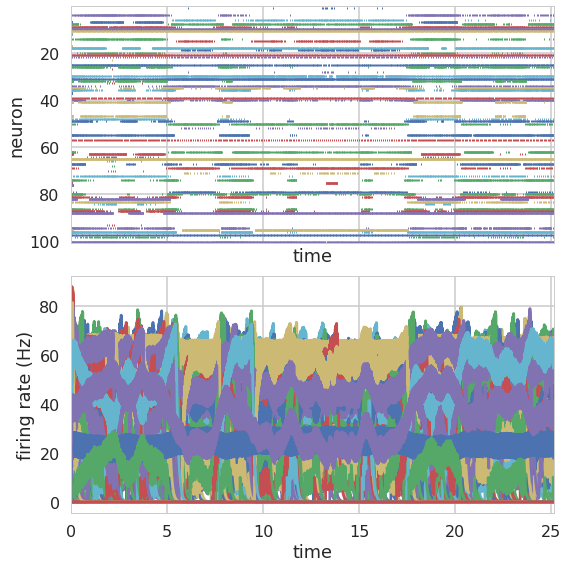

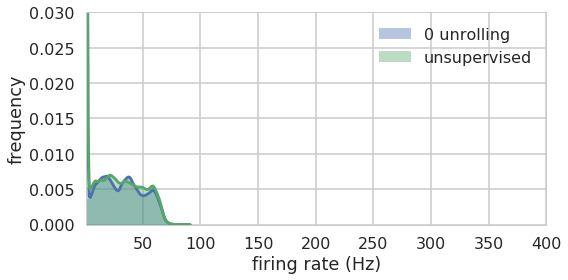

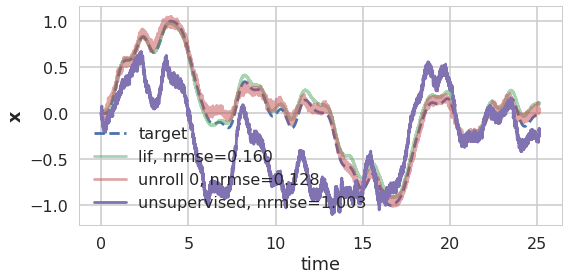

In [7]:
rng = np.random.RandomState(seed=1)
kwargs = dict(
    t=8*np.pi,
    dt=0.0001,
    dt_sample=0.001,
    n_neurons=100,
    n_pre=100,
    freq=1,
    amp=1,
    reg=0.01,
    gain=Uniform(-3, 3),
    bias=Uniform(-3, 3),
    max_rates=Default,
    neuron_type=WilsonNeuron(),
    taus={'network': 0.1, 'readout': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5})

d_best = unroll_best(n_unroll=10, **kwargs)

### 300 neurons

unrolling #0
Simulating finished in 0:02:57.                                                 
nrmse = 1.000
unrolling #1
Simulating finished in 0:03:51.                                                 
nrmse = 1.078
unrolling #2
Simulating finished in 0:05:05.                                                 
nrmse = 0.719
unrolling #3
Simulating finished in 0:03:55.                                                 
nrmse = 0.642
unrolling #4
Simulating finished in 0:05:34.                                                 
nrmse = 0.715
unrolling #5
Simulating finished in 0:05:00.                                                 
nrmse = 0.383
unrolling #6
Simulating finished in 0:05:37.                                                 
nrmse = 0.935
unrolling #7
Simulating finished in 0:05:08.                                                 
nrmse = 1.731
unrolling #8
Simulating finished in 0:06:20.                                                 
nrmse = 1.457
unrolling #9
Simulating fini

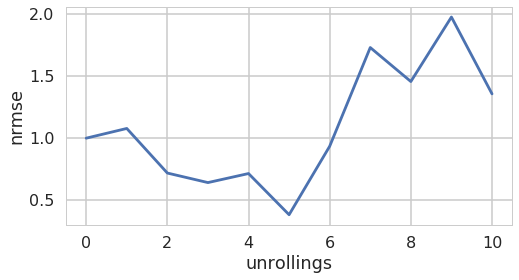

Simulating finished in 0:03:06.                                                 


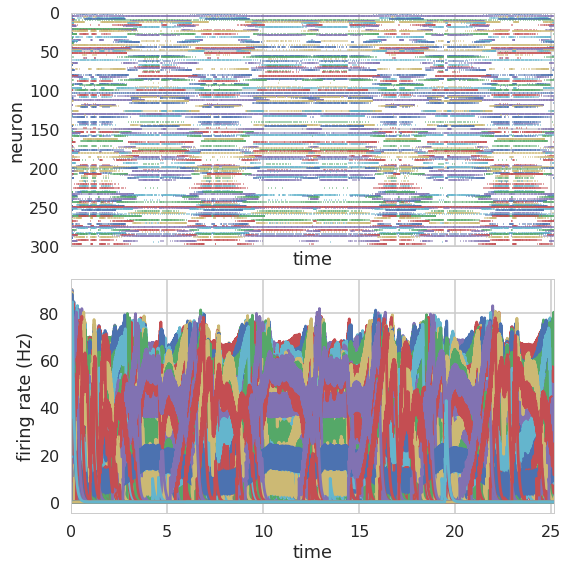

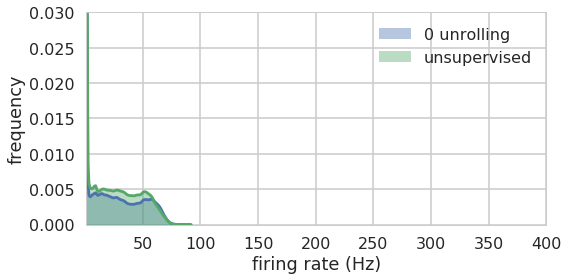

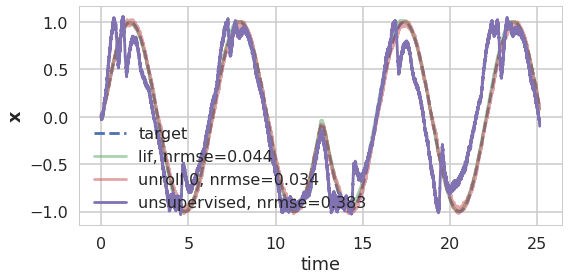

Simulating finished in 0:02:54.                                                 


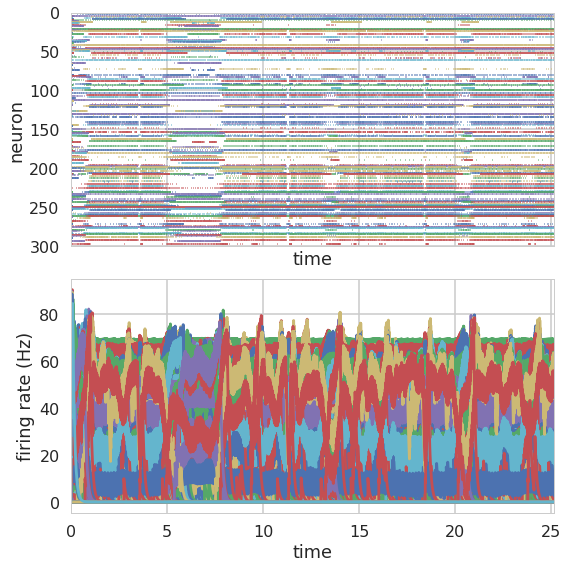

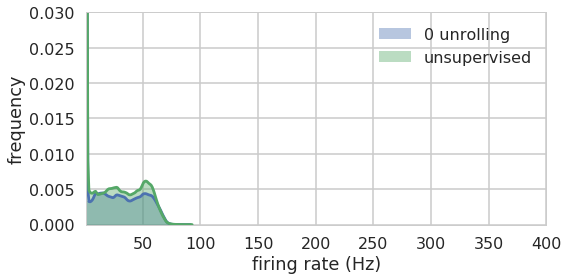

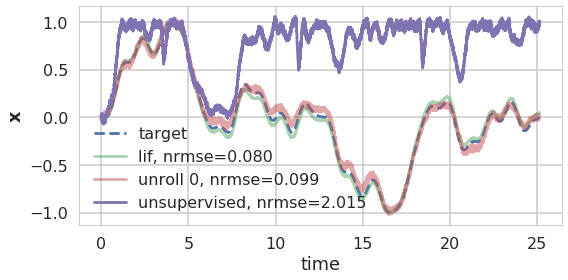

In [8]:
rng = np.random.RandomState(seed=1)
kwargs = dict(
    t=8*np.pi,
    dt=0.0001,
    dt_sample=0.001,
    n_neurons=300,
    n_pre=100,
    freq=1,
    amp=1,
    reg=0.01,
    gain=Uniform(-3, 3),
    bias=Uniform(-3, 3),
    max_rates=Default,
    neuron_type=WilsonNeuron(),
    taus={'network': 0.1, 'readout': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5})

d_best = unroll_best(n_unroll=10, **kwargs)

### reduce gain when n_neurons is large

unrolling #0
Simulating finished in 0:03:34.                                                 
nrmse = 1.000
unrolling #1
Simulating finished in 0:04:21.                                                 
nrmse = 0.804
unrolling #2
Simulating finished in 0:04:27.                                                 
nrmse = 1.393
unrolling #3
Simulating finished in 0:05:22.                                                 
nrmse = 1.302
unrolling #4
Simulating finished in 0:04:32.                                                 
nrmse = 0.895
unrolling #5
Simulating finished in 0:05:10.                                                 
nrmse = 1.529
unrolling #6
Simulating finished in 0:06:01.                                                 
nrmse = 0.500
unrolling #7
Simulating finished in 0:05:56.                                                 
nrmse = 1.658
unrolling #8
Simulating finished in 0:06:10.                                                 
nrmse = 1.838
unrolling #9
Simulating fini

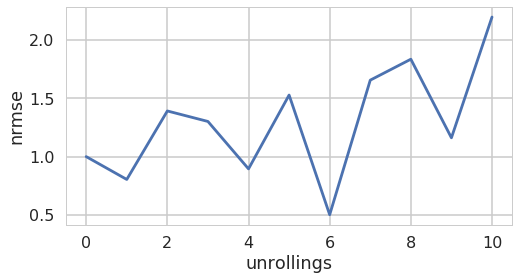

Simulating finished in 0:02:54.                                                 


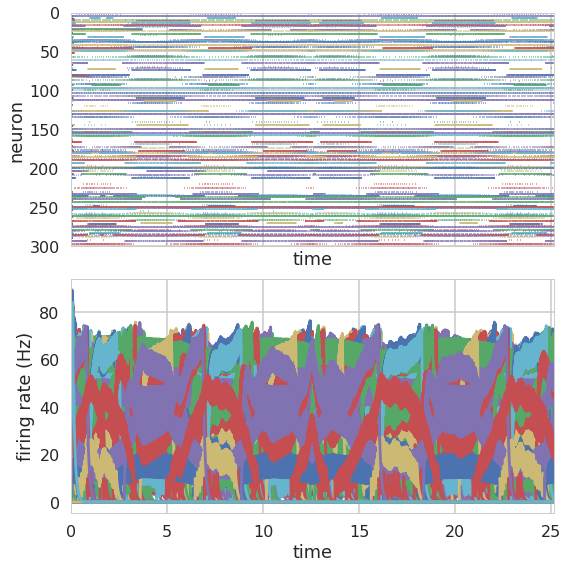

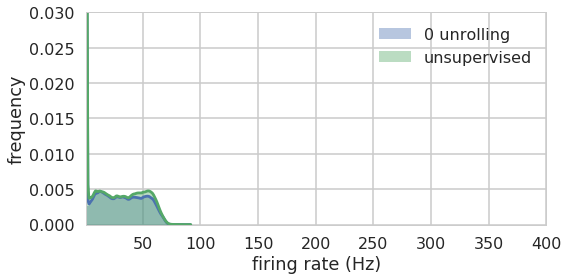

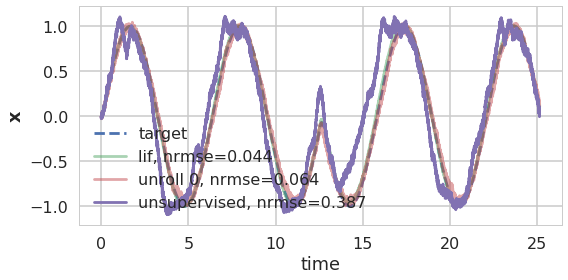

Simulating finished in 0:04:01.                                                 


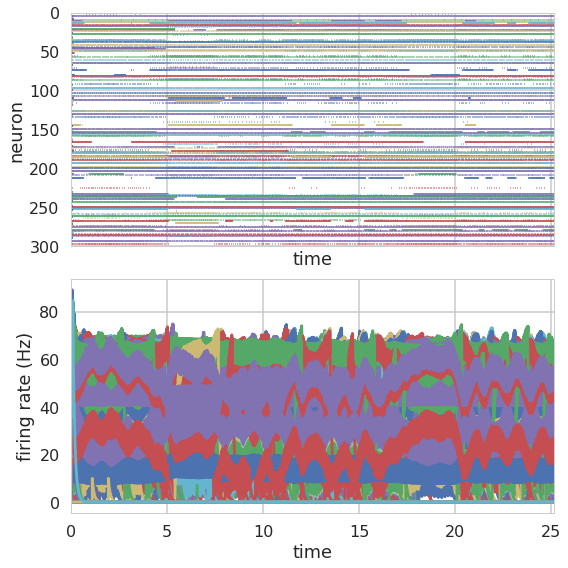

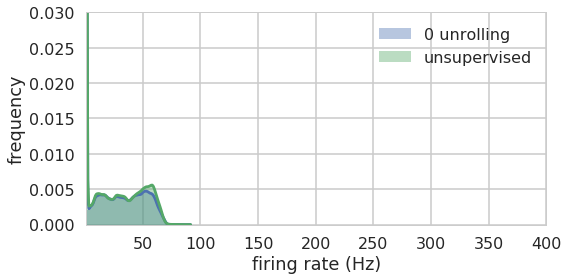

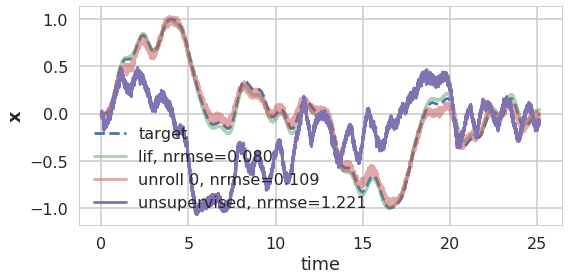

In [10]:
rng = np.random.RandomState(seed=1)
kwargs = dict(
    t=8*np.pi,
    dt=0.0001,
    dt_sample=0.001,
    n_neurons=300,
    n_pre=100,
    freq=1,
    amp=1,
    reg=0.01,
    gain=Uniform(-1, 1),
    bias=Uniform(-3, 3),
    max_rates=Default,
    neuron_type=WilsonNeuron(),
    taus={'network': 0.1, 'readout': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5})

d_best = unroll_best(n_unroll=10, **kwargs)

unrolling #0
Simulating finished in 0:03:03.                                                 
nrmse = 1.000
unrolling #1
Simulating finished in 0:04:35.                                                 
nrmse = 1.711
unrolling #2
Simulating finished in 0:03:52.                                                 
nrmse = 0.816
unrolling #3
Simulating finished in 0:04:41.                                                 
nrmse = 1.568
unrolling #4
Simulating finished in 0:04:53.                                                 
nrmse = 1.601
unrolling #5
Simulating finished in 0:05:33.                                                 
nrmse = 1.637
unrolling #6
Simulating finished in 0:05:54.                                                 
nrmse = 1.581
unrolling #7
Simulating finished in 0:05:41.                                                 
nrmse = 1.604
unrolling #8
Simulating finished in 0:05:30.                                                 
nrmse = 1.534
unrolling #9
Simulating fini

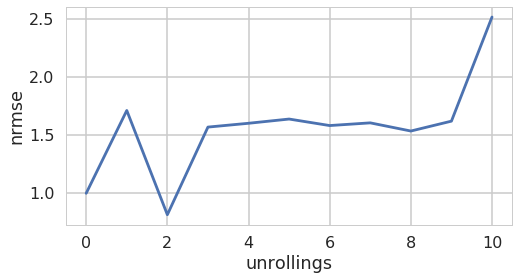

Simulating finished in 0:02:54.                                                 


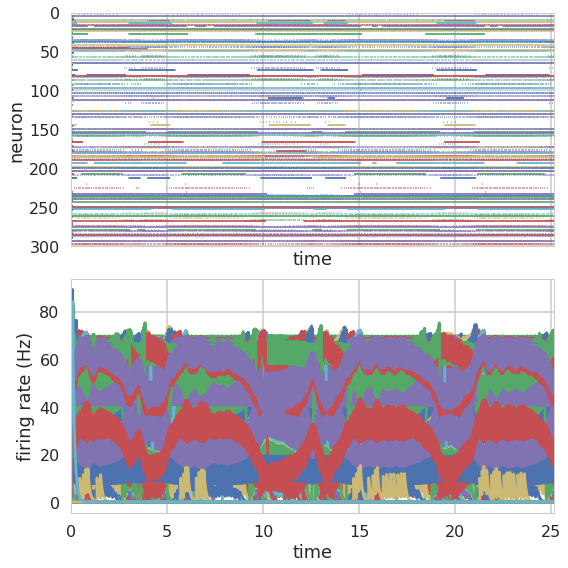

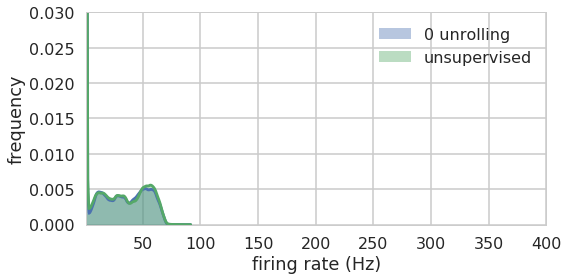

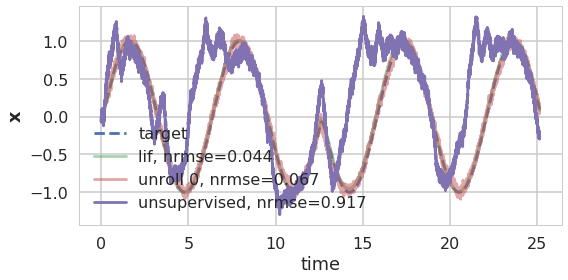

Simulating finished in 0:03:02.                                                 


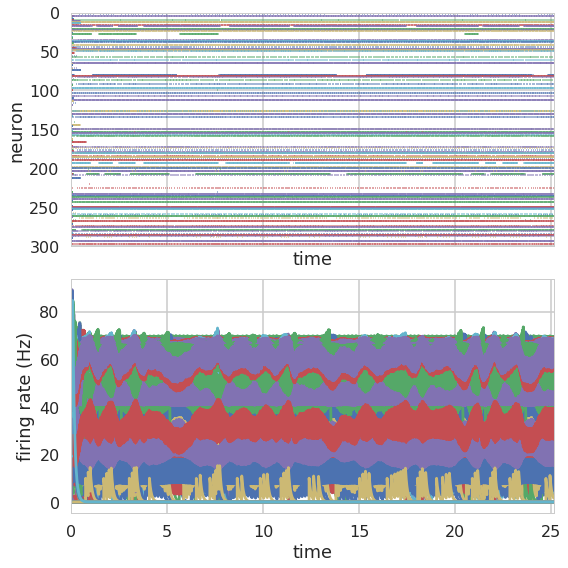

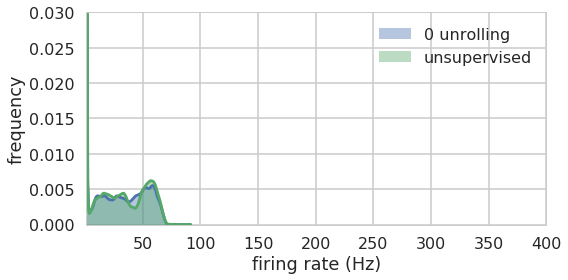

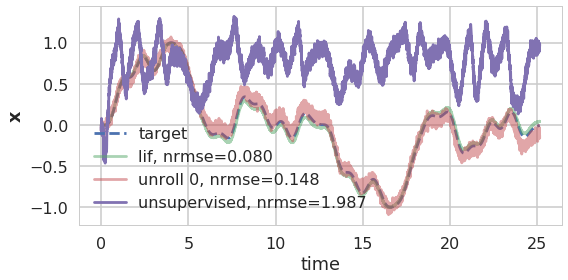

In [11]:
rng = np.random.RandomState(seed=1)
kwargs = dict(
    t=8*np.pi,
    dt=0.0001,
    dt_sample=0.001,
    n_neurons=300,
    n_pre=100,
    freq=1,
    amp=1,
    reg=0.01,
    gain=Uniform(-0.5, 0.5),
    bias=Uniform(-3, 3),
    max_rates=Default,
    neuron_type=WilsonNeuron(),
    taus={'network': 0.1, 'readout': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5})

d_best = unroll_best(n_unroll=10, **kwargs)

unrolling #0
Simulating finished in 0:03:29.                                                 
nrmse = 1.000
unrolling #1
Simulating finished in 0:05:02.                                                 
nrmse = 1.458
unrolling #2
Simulating finished in 0:04:44.                                                 
nrmse = 0.451
unrolling #3
Simulating finished in 0:07:16.                                                 
nrmse = 0.512
unrolling #4
Simulating finished in 0:07:01.                                                 
nrmse = 0.358
unrolling #5
Simulating finished in 0:07:37.                                                 
nrmse = 0.939


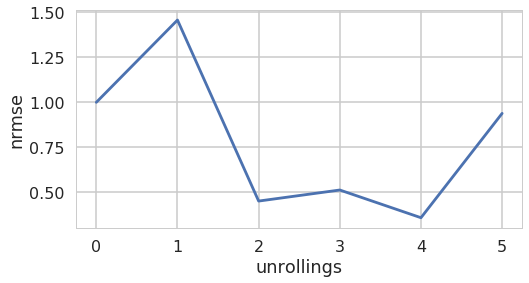

Simulating finished in 0:04:52.                                                 


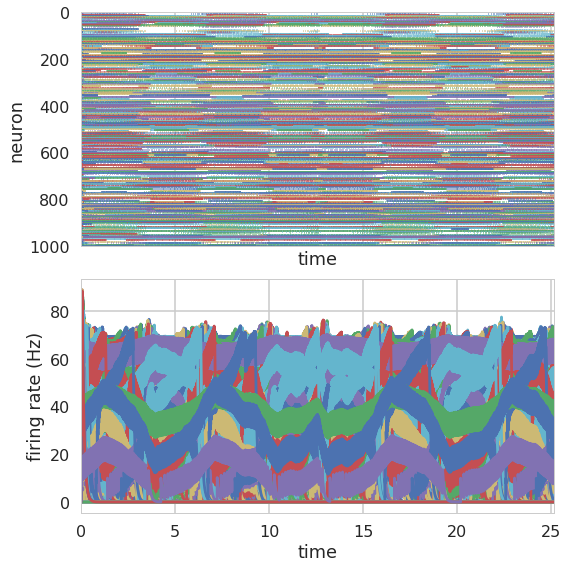

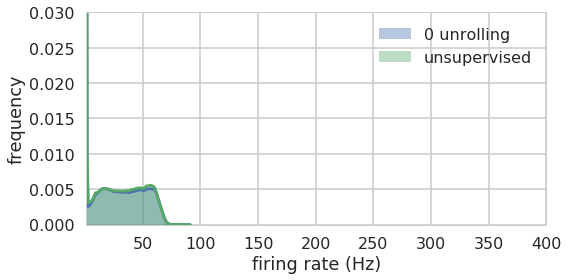

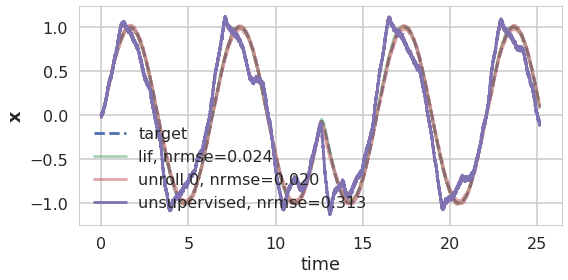

Simulating finished in 0:03:00.                                                 


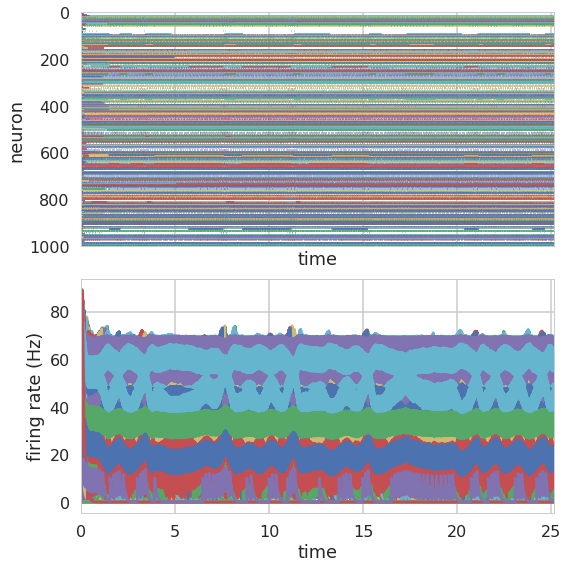

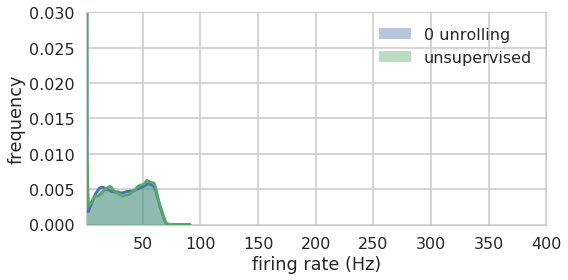

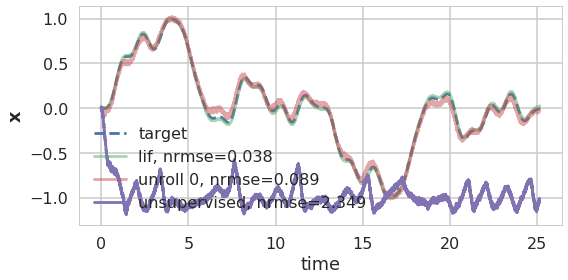

In [6]:
rng = np.random.RandomState(seed=1)
kwargs = dict(
    t=8*np.pi,
    dt=0.0001,
    dt_sample=0.001,
    n_neurons=1000,
    n_pre=100,
    freq=1,
    amp=1,
    reg=0.01,
    gain=Uniform(-1, 1),
    bias=Uniform(-3, 3),
    max_rates=Default,
    neuron_type=WilsonNeuron(),
    taus={'network': 0.1, 'readout': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5})

d_best = unroll_best(n_unroll=5, **kwargs)

### white_noise

unrolling #0
Simulating finished in 0:02:53.                                                 
nrmse = 1.000
unrolling #1
Simulating finished in 0:02:44.                                                 
nrmse = 1.350
unrolling #2
Simulating finished in 0:04:21.                                                 
nrmse = 1.530
unrolling #3
Simulating finished in 0:04:23.                                                 
nrmse = 2.234
unrolling #4
Simulating finished in 0:04:41.                                                 
nrmse = 1.377
unrolling #5
Simulating finished in 0:05:46.                                                 
nrmse = 1.824
unrolling #6
Simulating finished in 0:04:30.                                                 
nrmse = 0.737
unrolling #7
Simulating finished in 0:06:12.                                                 
nrmse = 2.302
unrolling #8
Simulating finished in 0:06:35.                                                 
nrmse = 0.978
unrolling #9
Simulating fini

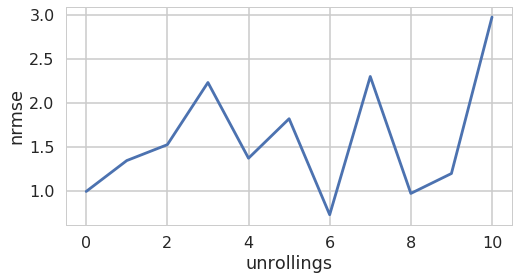

Simulating finished in 0:04:05.                                                 


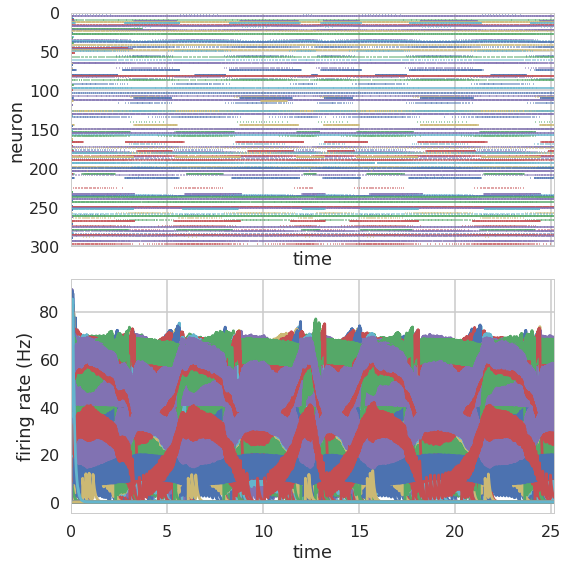

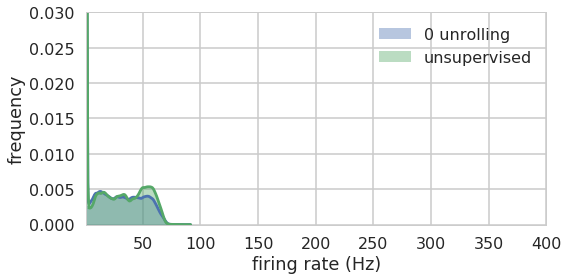

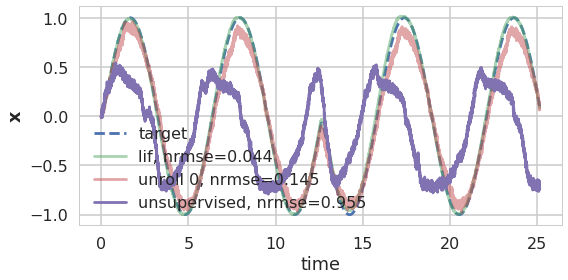

Simulating finished in 0:02:58.                                                 


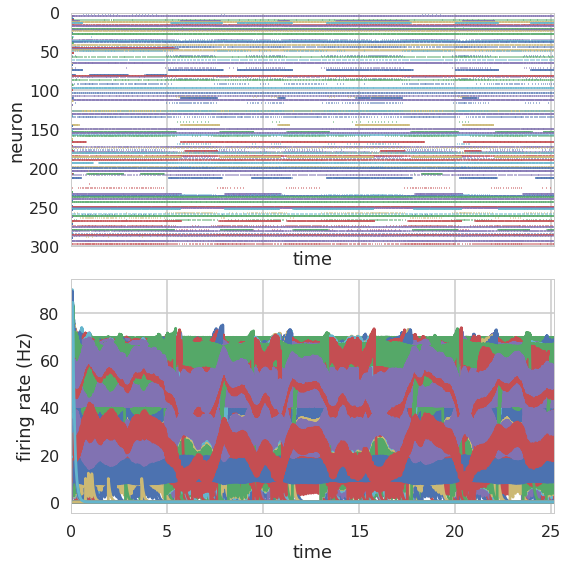

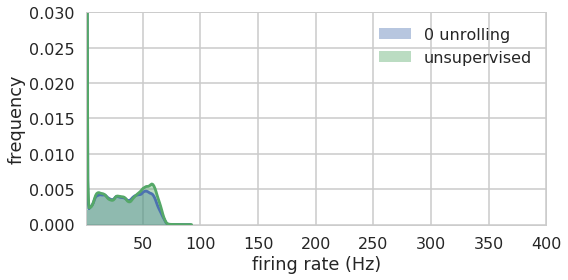

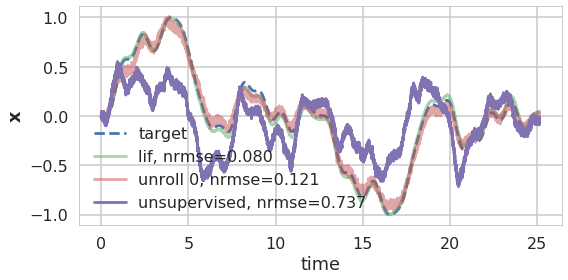

In [7]:
rng = np.random.RandomState(seed=1)
kwargs = dict(
    t=8*np.pi,
    dt=0.0001,
    dt_sample=0.001,
    n_neurons=300,
    n_pre=100,
    freq=1,
    amp=1,
    reg=0.01,
    gain=Uniform(-1, 1),
    bias=Uniform(-3, 3),
    max_rates=Default,
    neuron_type=WilsonNeuron(),
    taus={'network': 0.1, 'readout': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5})

d_best = unroll_best(n_unroll=10, signal='white_noise', **kwargs)

### reduced bias

unrolling #0


/home/pduggins/.virtualenvs/nengo_bioneuron/local/lib/python2.7/site-packages/nengolib/signal/system.py:197: UserWarning: y0 (None!=0) does not properly initialize the system; see Nengo issue #1124.
  "Nengo issue #1124." % y0, UserWarning)


Simulating finished in 0:04:09.                                                 
nrmse = 1.000
unrolling #1
Simulating finished in 0:05:00.                                                 
nrmse = 1.568
unrolling #2
Simulating finished in 0:07:59.                                                 
nrmse = 1.431
unrolling #3
Simulating finished in 0:06:55.                                                 
nrmse = 1.369
unrolling #4
Simulating finished in 0:08:39.                                                 
nrmse = 1.306
unrolling #5
Simulating finished in 0:07:55.                                                 
nrmse = 1.284
unrolling #6
Simulating finished in 0:09:25.                                                 
nrmse = 1.244
unrolling #7
Simulating finished in 0:11:26.                                                 
nrmse = 1.307
unrolling #8
Simulating finished in 0:11:41.                                                 
nrmse = 1.332
unrolling #9
Simulating finished in 0:09:

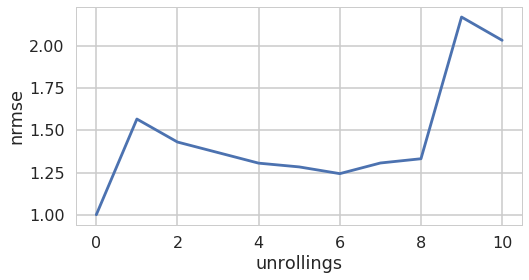

Simulating finished in 0:06:36.                                                 


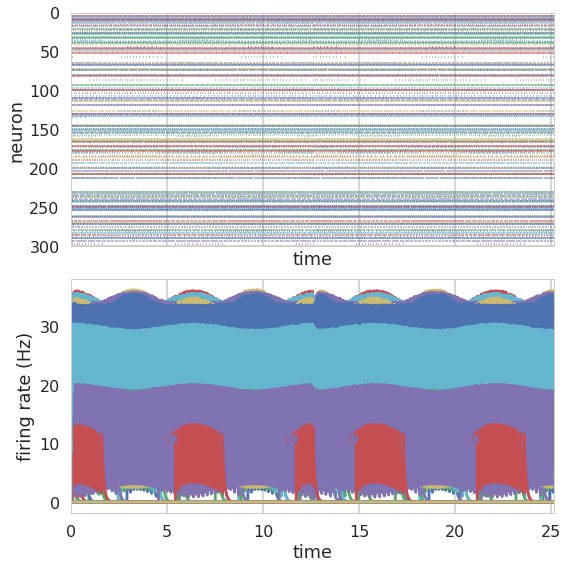

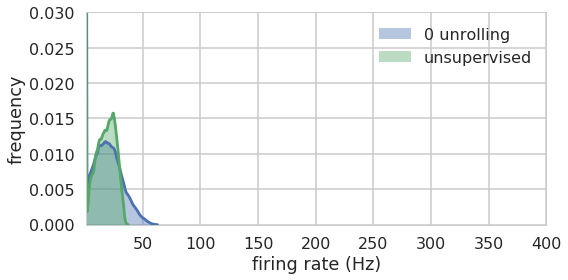

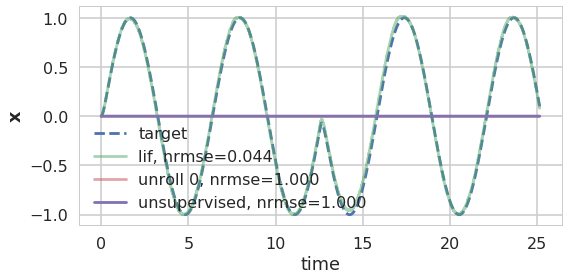

Simulating finished in 0:07:01.                                                 


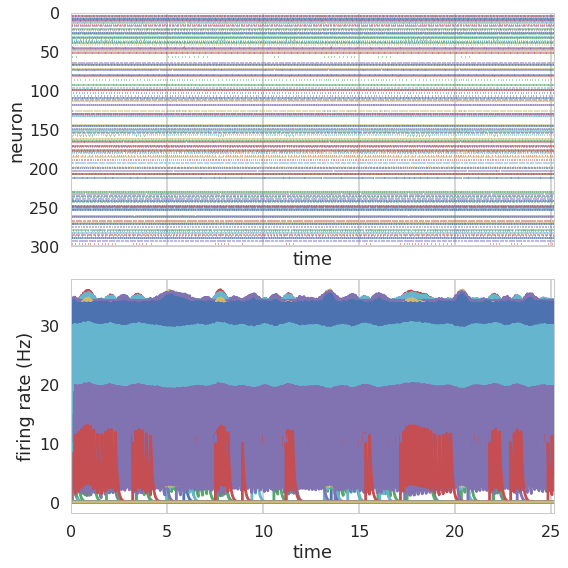

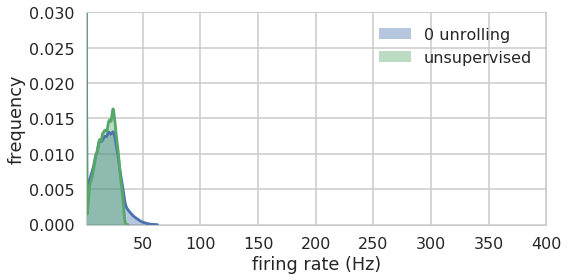

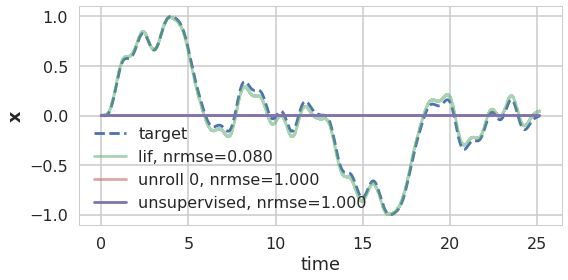

In [6]:
rng = np.random.RandomState(seed=1)
kwargs = dict(
    t=8*np.pi,
    dt=0.0001,
    dt_sample=0.001,
    n_neurons=300,
    n_pre=100,
    freq=1,
    amp=1,
    reg=0.01,
    gain=Uniform(-1, 1),
    bias=Uniform(-1, 1),
    max_rates=Default,
    neuron_type=WilsonNeuron(),
    taus={'network': 0.1, 'readout': 0.1},
    seeds={'ns': 1, 'ss':2, 'es': 3, 'cs': 4, 'ls': 5})

d_best = unroll_best(n_unroll=10, signal='white_noise', **kwargs)

### longer training time